This notebook contains the CNN model used in the manuscript.
The CNN is trained on keypoint sequences from the pose estimation model to learn gait parameters obtained from the GaitRite 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import os
from scipy.stats import pearsonr
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.model_selection import LeavePGroupsOut, GroupKFold, LeaveOneGroupOut

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

tf.random.set_seed(1234)
np.random.seed(1234)

In [2]:
datapath = '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets'
figs_path = '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [4]:
#defines the model
def buildCNN(input_shape, model_name='gait_model', n_outputs=1):
    regularizer = tf.keras.regularizers.L1L2(l1=0, l2=0)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2, strides=2),
#         layers.Dropout(0),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2, strides=2),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(n_outputs, activation='linear')
    ], name=model_name)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return model

In [5]:
#Augmenter and generator parameters
# tf.random.set_seed(1234)
BATCH_SIZE = 32

def aug(x, y):
    if True:
        x = x + tf.random.normal(mean=0, stddev=0.0, shape=tf.shape(x))
        y = y + tf.random.normal(mean=0, stddev=0.01, shape=tf.shape(y))
    elif False:
        # this should be trivial data to solve
        x = x*0 + y*1
    else:
        pass
    return x, y


def rescale_data(data,ym,yM):
    data_res = (yM - ym)*(data + 1)*0.5 + ym
    return data_res

# Load and Prepare Data

In [6]:
#load data
data = np.load('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/Input_Heel_Toe_AnkleLR_KneeLR_medfilt.npy') #(Batch, Time, 1, Channel/keypoint)
labels = np.load('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/labels_walkspd_subjcodes_LRankle_knee_medfilt.npy') #[gait parameters, videoId]

data = np.squeeze(data) #(Batch, Time, Channel) #remove extra dimension if present
data, labels = data.astype(np.float32), labels.astype(np.float32)

videoid_map = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/videoid_map.csv', index_col=0).drop_duplicates()
SubjCodes = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/SubjCodes.csv')

data = np.nan_to_num(data)
labels = np.nan_to_num(labels)
print(data.shape, labels.shape)

(656, 120, 10) (656, 11)


In [7]:
labels

array([[ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       [ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       [ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       ...,
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ],
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ],
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ]],
      dtype=float32)

In [9]:
# videoid_map

In [99]:
SubjCodes.Video_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81])

In [100]:
assert len(SubjCodes) == len(labels)

In [101]:
data.shape
# data[0]

(656, 120, 10)

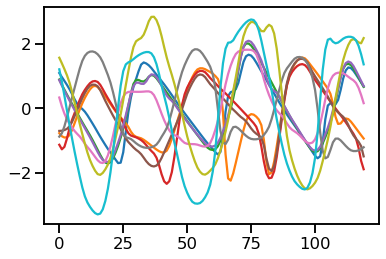

In [102]:
plt.plot(data[499]) # a poor detection example

In [8]:
#L-R Data
labels_all = {'swingL':labels[:,0:1], 'swingR':labels[:,1:2],
              'stanceL':labels[:,2:3], 'stanceR':labels[:,3:4],
              'asymmetry_swing':labels[:,4:5], 'asymmetry_stance':labels[:,5:6],
             'cadence':labels[:,6:7], 'walking_spd':labels[:,7:8], 'DST':labels[:,8:9], 
              'video_id':labels[:,-2], 'SubjCode':labels[:,-1]}

#if P-NP data

# labels_all = {'swingP':labels[:,0:1], 'stanceP':labels[:,1:2],
#               'swingNP':labels[:,2:3], 'stanceNP':labels[:,3:4],
#               'asymmetry_swing':labels[:,4:5], 'asymmetry_stance':labels[:,5:6],
#              'cadence':labels[:,6:7], 'walking_spd':labels[:,7:8], 'DST':labels[:,8:9], 
#               'video_id':labels[:,-2], 'SubjCode':labels[:,-1]}

In [15]:
labels[12]

array([ 0.387    ,  0.641    ,  1.74     ,  1.517    , 24.708172 ,
        6.8467917, 56.4      ,  0.387    ,  1.0955   ,  3.       ,
        0.       ], dtype=float32)

In [16]:
# labels_all['video_id'][669]

# Train model on each gait parameter individually
This is used to train one CNN for each gait parameter (single output CNN) - as presented in the paper

In [17]:
len(np.unique(labels_all['video_id']))

73

In [9]:
results = {}

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
#Train model on each parameter individually
par = ['walking_spd','cadence','DST','swingL','stanceL','swingR','stanceR'] #the set of parameters to learn
# par = ['walking_spd','cadence','DST','swingP','stanceP','swingNP','stanceNP']
# par = ['swingR']
model_file = 'results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee'

for gait_par in par:
    labels = labels_all[gait_par]
    # #rescale targets
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    labels = 2*(labels - ym)/(yM-ym) - 1 #rescaling between -1 and 1

    #kFold CV Loop
    print(gait_par)
    try: 
        results.update({gait_par: {'pred':[], 'labels':[], 'test_group':[], 'video_id':[] ,'history':[], 
                                  'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}})
    except NameError:
        results = {gait_par : {'pred':[], 'labels':[], 'test_group':[], 'video_id':[], 'history':[],
                  'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}}

#     groups = labels_all['videoId'] #Leave-k-videos out CV (can include same subject)
    groups = labels_all['SubjCode'] #LOSOCV 
    group_kfold = LeaveOneGroupOut()
    print(f'N_folds = {group_kfold.get_n_splits(data, labels, groups)}')

    for train_idx, test_idx in group_kfold.split(data, labels, groups):
        SHUFFLE_BUFFER_SIZE = len(train_idx)

        #split data and create data generator
        data_train, labels_train = data[train_idx], labels[train_idx]
        data_test, labels_test = data[test_idx], labels[test_idx]
        train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)) 
        test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))
        
#         train_ds = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) #w/o data aug
        train_ds = train_dataset.batch(BATCH_SIZE) #w/o data aug and shuffle
        train_ds = train_dataset.map(aug).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) 
        val_ds = test_dataset.batch(BATCH_SIZE)

        #compile model
        for x, _ in train_dataset.take(1): 
            input_shape = x.shape
            model = buildCNN(input_shape, gait_par) #single output net

        #fit model and save predictions
        history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=True, 
                            callbacks=[callback])
        print(f'model trained - train size = {len(train_idx)}, test size = {len(test_idx)}')
        hist = pd.DataFrame(history.history)

        #store results for current run
        results[gait_par]['pred'].append(model.predict(tf.convert_to_tensor(data_test)))
        results[gait_par]['labels'].append(labels_test)
        results[gait_par]['test_group'].append(groups[test_idx])
        results[gait_par]['video_id'].append(labels_all['video_id'][test_idx])
        results[gait_par]['history'].append(hist)
        
        #store results on training set (for debug)
        results[gait_par]['train']['pred'].append(model.predict(tf.convert_to_tensor(data_train)))
        results[gait_par]['train']['labels'].append(labels_train)
        results[gait_par]['train']['test_group'].append(groups[train_idx])
        results[gait_par]['train']['video_id'].append(labels_all['video_id'][train_idx])
    

walking_spd
N_folds = 8
Epoch 1/200
17/17 [==============================] - 3s 32ms/step - loss: 0.6306 - val_loss: 0.3945
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2119 - val_loss: 0.2739
Epoch 3/200
17/17 [==============================] - 0s 10ms/step - loss: 0.2011 - val_loss: 0.2123
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1250 - val_loss: 0.2225
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1437 - val_loss: 0.2396
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1261 - val_loss: 0.0948
Epoch 7/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.0861
Epoch 8/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0877 - val_loss: 0.1357
Epoch 9/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0835 - val_loss: 0.0990
Epoch 10/200
17/17 [==============================] - 0s 9ms/step - loss: 0.

Epoch 14/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1366 - val_loss: 0.2018
Epoch 15/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0928 - val_loss: 0.2264
Epoch 16/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0982 - val_loss: 0.2951
Epoch 17/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0809 - val_loss: 0.2737
Epoch 18/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0812 - val_loss: 0.1973
Epoch 19/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0745 - val_loss: 0.2730
Epoch 20/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0747 - val_loss: 0.1858
Epoch 21/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0657 - val_loss: 0.1543
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0621 - val_loss: 0.2271
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0572 - val_loss:

14/14 [==============================] - 0s 12ms/step - loss: 0.0347 - val_loss: 0.0461
Epoch 29/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0327 - val_loss: 0.0342
Epoch 30/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0394 - val_loss: 0.0369
Epoch 31/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0386 - val_loss: 0.0423
Epoch 32/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0418 - val_loss: 0.0462
Epoch 33/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0600
Epoch 34/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0332 - val_loss: 0.0485
Epoch 35/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0286 - val_loss: 0.0408
Epoch 36/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0347 - val_loss: 0.0487
Epoch 37/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0301 - val_loss: 0.0595
Epo

17/17 [==============================] - 0s 9ms/step - loss: 0.0436 - val_loss: 0.0603
Epoch 17/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0482 - val_loss: 0.0566
Epoch 18/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0383 - val_loss: 0.0543
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0366 - val_loss: 0.0402
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0464 - val_loss: 0.0469
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0414 - val_loss: 0.0286
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0274 - val_loss: 0.0501
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0372
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0301 - val_loss: 0.0300
Epoch 25/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0283 - val_loss: 0.0272
Epoc

18/18 [==============================] - 0s 9ms/step - loss: 0.0385 - val_loss: 0.0636
Epoch 18/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0340 - val_loss: 0.0924
Epoch 19/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0325 - val_loss: 0.0799
Epoch 20/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0285 - val_loss: 0.0781
Epoch 21/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0388 - val_loss: 0.0862
Epoch 22/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0805
Epoch 23/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0308 - val_loss: 0.1011
Epoch 24/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0226 - val_loss: 0.0810
model trained - train size = 556, test size = 28
Epoch 1/200
17/17 [==============================] - 1s 16ms/step - loss: 1.3418 - val_loss: 0.4506
Epoch 2/200
17/17 [==============================] - 0s 9ms

14/14 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0726
Epoch 35/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0207 - val_loss: 0.0543
Epoch 36/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0615
Epoch 37/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0150 - val_loss: 0.0422
Epoch 38/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0679
Epoch 39/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0142 - val_loss: 0.0607
Epoch 40/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0565
Epoch 41/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0125 - val_loss: 0.0438
Epoch 42/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0126 - val_loss: 0.0489
Epoch 43/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0133 - val_loss: 0.0436
Epo

15/15 [==============================] - 0s 10ms/step - loss: 0.2004 - val_loss: 0.5215
Epoch 3/200
15/15 [==============================] - 0s 10ms/step - loss: 0.1696 - val_loss: 0.5017
Epoch 4/200
15/15 [==============================] - 0s 10ms/step - loss: 0.1335 - val_loss: 0.4814
Epoch 5/200
15/15 [==============================] - 0s 10ms/step - loss: 0.1529 - val_loss: 0.5173
Epoch 6/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0934 - val_loss: 0.4758
Epoch 7/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1029 - val_loss: 0.4233
Epoch 8/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0859 - val_loss: 0.4291
Epoch 9/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0830 - val_loss: 0.4327
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0943 - val_loss: 0.4671
Epoch 11/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0660 - val_loss: 0.5123
Epoch 12/2

17/17 [==============================] - 0s 11ms/step - loss: 0.0677 - val_loss: 0.0606
Epoch 13/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0592 - val_loss: 0.0666
Epoch 14/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0457 - val_loss: 0.0678
Epoch 15/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0413 - val_loss: 0.0713
Epoch 16/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0437 - val_loss: 0.0653
Epoch 17/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0380 - val_loss: 0.0481
Epoch 18/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0428 - val_loss: 0.0499
Epoch 19/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0472 - val_loss: 0.0634
Epoch 20/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0.0675
Epoch 21/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0362 - val_loss: 0.0640
Epo

18/18 [==============================] - 0s 10ms/step - loss: 0.2348 - val_loss: 0.4443
Epoch 6/200
18/18 [==============================] - 0s 9ms/step - loss: 0.2649 - val_loss: 0.1355
Epoch 7/200
18/18 [==============================] - 0s 9ms/step - loss: 0.1799 - val_loss: 0.2741
Epoch 8/200
18/18 [==============================] - 0s 9ms/step - loss: 0.1390 - val_loss: 0.1583
Epoch 9/200
18/18 [==============================] - 0s 10ms/step - loss: 0.1142 - val_loss: 0.2405
Epoch 10/200
18/18 [==============================] - 0s 10ms/step - loss: 0.1131 - val_loss: 0.1500
Epoch 11/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0949 - val_loss: 0.1565
Epoch 12/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0820 - val_loss: 0.1879
Epoch 13/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0839 - val_loss: 0.1283
Epoch 14/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0605 - val_loss: 0.1231
Epoch 15/2

15/15 [==============================] - 0s 10ms/step - loss: 0.0497 - val_loss: 0.2438
Epoch 25/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0495 - val_loss: 0.2724
Epoch 26/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0752 - val_loss: 0.1996
Epoch 27/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0382 - val_loss: 0.2309
Epoch 28/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0414 - val_loss: 0.2287
Epoch 29/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0304 - val_loss: 0.2201
Epoch 30/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0341 - val_loss: 0.2318
Epoch 31/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0307 - val_loss: 0.2172
Epoch 32/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0365 - val_loss: 0.2484
Epoch 33/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0304 - val_loss: 0.2462
Epo

17/17 [==============================] - 0s 11ms/step - loss: 0.0551 - val_loss: 0.1580
Epoch 18/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0547 - val_loss: 0.1851
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0479 - val_loss: 0.1987
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0450 - val_loss: 0.0703
Epoch 21/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0513 - val_loss: 0.0935
Epoch 22/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0314 - val_loss: 0.0884
Epoch 23/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0366 - val_loss: 0.1129
Epoch 24/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0417 - val_loss: 0.1387
Epoch 25/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0386 - val_loss: 0.1186
Epoch 26/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0239 - val_loss: 0.1597
Epoch

18/18 [==============================] - 0s 9ms/step - loss: 0.1360 - val_loss: 0.0540
Epoch 11/200
18/18 [==============================] - 0s 10ms/step - loss: 0.1474 - val_loss: 0.0778
model trained - train size = 552, test size = 32
stanceL
N_folds = 8
Epoch 1/200
17/17 [==============================] - 1s 17ms/step - loss: 1.0892 - val_loss: 0.1529
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.3525 - val_loss: 0.1445
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2674 - val_loss: 0.1507
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2140 - val_loss: 0.1493
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2250 - val_loss: 0.1712
Epoch 6/200
17/17 [==============================] - 0s 9ms/step - loss: 0.1437 - val_loss: 0.1215
Epoch 7/200
17/17 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.0871
Epoch 8/200
17/17 [=========================

Epoch 27/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0242 - val_loss: 0.0302
Epoch 28/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0276 - val_loss: 0.0963
Epoch 29/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0280 - val_loss: 0.0539
Epoch 30/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.1966
Epoch 31/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0260 - val_loss: 0.1140
Epoch 32/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 0.0319
Epoch 33/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.0414
Epoch 34/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0211 - val_loss: 0.0372
Epoch 35/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0156 - val_loss: 0.0569
Epoch 36/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 

16/16 [==============================] - 0s 10ms/step - loss: 0.1010 - val_loss: 0.0570
Epoch 8/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0969 - val_loss: 0.1090
Epoch 9/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0900 - val_loss: 0.0868
Epoch 10/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0797 - val_loss: 0.0474
Epoch 11/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0828 - val_loss: 0.1014
Epoch 12/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0641 - val_loss: 0.0740
Epoch 13/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0573 - val_loss: 0.0722
Epoch 14/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0530 - val_loss: 0.0639
Epoch 15/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0478 - val_loss: 0.0802
Epoch 16/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0450 - val_loss: 0.0429
Epoch

Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3960 - val_loss: 0.1472
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.4263 - val_loss: 0.1183
Epoch 5/200
15/15 [==============================] - 0s 11ms/step - loss: 0.3181 - val_loss: 0.2970
Epoch 6/200
15/15 [==============================] - 0s 10ms/step - loss: 0.2573 - val_loss: 0.2307
Epoch 7/200
15/15 [==============================] - 0s 11ms/step - loss: 0.2041 - val_loss: 0.3262
Epoch 8/200
15/15 [==============================] - 0s 10ms/step - loss: 0.1814 - val_loss: 0.1436
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1575 - val_loss: 0.2286
Epoch 10/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1793 - val_loss: 0.1292
Epoch 11/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1415 - val_loss: 0.2841
model trained - train size = 454, test size = 130
Epoch 1/200
18/18 [=============================

14/14 [==============================] - 0s 11ms/step - loss: 0.2913 - val_loss: 0.4315
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 0.2466 - val_loss: 0.3413
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.2059 - val_loss: 0.4275
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 0.1635 - val_loss: 0.4569
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - loss: 0.1425 - val_loss: 0.3810
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 0.1183 - val_loss: 0.4006
Epoch 9/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0945 - val_loss: 0.5254
Epoch 10/200
14/14 [==============================] - 0s 11ms/step - loss: 0.1035 - val_loss: 0.4754
Epoch 11/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0753 - val_loss: 0.2449
Epoch 12/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0727 - val_loss: 0.2825
Epoch 13/

Epoch 63/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0505
Epoch 64/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0118 - val_loss: 0.0200
Epoch 65/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.0193
Epoch 66/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 67/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0161
Epoch 68/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0341
Epoch 69/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0157 - val_loss: 0.0371
Epoch 70/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0105 - val_loss: 0.0251
Epoch 71/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0106 - val_loss: 0.0200
Epoch 72/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0106 - val_los

Epoch 23/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0427 - val_loss: 0.4965
Epoch 24/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0342 - val_loss: 0.4693
Epoch 25/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0367 - val_loss: 0.5151
Epoch 26/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0296 - val_loss: 0.4717
Epoch 27/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0288 - val_loss: 0.3839
Epoch 28/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0366 - val_loss: 0.4151
Epoch 29/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0261 - val_loss: 0.4138
Epoch 30/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0368 - val_loss: 0.3530
Epoch 31/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0291 - val_loss: 0.4398
Epoch 32/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0270 - val_los

17/17 [==============================] - 0s 10ms/step - loss: 0.0695 - val_loss: 0.1504
Epoch 18/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0703 - val_loss: 0.0773
Epoch 19/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0560 - val_loss: 0.1458
Epoch 20/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0522 - val_loss: 0.0414
Epoch 21/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0519 - val_loss: 0.1066
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0574 - val_loss: 0.0761
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0431 - val_loss: 0.0525
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0457 - val_loss: 0.0955
Epoch 25/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0423 - val_loss: 0.0515
Epoch 26/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0446 - val_loss: 0.0868
Epoc

16/16 [==============================] - 0s 11ms/step - loss: 0.1242 - val_loss: 0.0706
Epoch 11/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0911 - val_loss: 0.1177
Epoch 12/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0833 - val_loss: 0.0594
Epoch 13/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0821 - val_loss: 0.0544
Epoch 14/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0632 - val_loss: 0.0749
Epoch 15/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0799 - val_loss: 0.0352
Epoch 16/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0616 - val_loss: 0.0448
Epoch 17/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0531 - val_loss: 0.0688
Epoch 18/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0457 - val_loss: 0.0682
Epoch 19/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0599 - val_loss: 0.0364
Epo

In [21]:
model.summary()
print(model_file)

Model: "stanceR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 113, 32)           2592      
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 106, 32)           8224      
_________________________________________________________________
batch_normalization_110 (Bat (None, 106, 32)           128       
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 53, 32)            0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 46, 32)            8224      
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 39, 32)            8224      
_________________________________________________________________
batch_normalization_111 (Bat (None, 39, 32)            128 

In [22]:
#Save model
print(len(results[gait_par]['pred']))
np.save(os.path.join('./results/',model_file+'.npy'), results, allow_pickle=True)
print('saved ./results/',model_file+'.npy')

8
saved ./results/ results_loso_AlphaPose_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee.npy


# Train model on multiple outputs 
This is used to train a single CNN on all the GaitRite parameters (multiple outputs CNN)

In [11]:
#select parameters to train
gait_par = ['walking_spd','cadence','DST','swingL','stanceL','swingR','stanceR']
labels = [labels_all[g] for g in gait_par]
labels = np.concatenate(labels, axis=1)
print(labels.shape)
# #rescale targets
ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
labels = 2*(labels - ym)/(yM-ym) - 1 #rescaling between -1 and 1
print(ym, yM)
print(data.shape, labels.shape)
print(np.min(labels, axis=0))
print(np.max(labels, axis=0))

gait_par = 'multioutput' #name model and dictionary

(656, 7)
[ 0.235 43.1    0.293  0.254  0.579  0.223  0.669] [  1.124  112.9      1.6805   0.766    2.073    0.714    2.397 ]
(656, 120, 10) (656, 7)
[-1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1.]


In [12]:
#kFold CV Loop - Train on 1 or multiple parameters (multi-output network)
model_file = 'results_loso_MultiOut_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee'

print(gait_par)
try: 
    results.update({gait_par: {'pred':[], 'labels':[], 'test_group':[], 'video_id':[] ,'history':[], 
                              'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}})
except NameError:
    results = {gait_par : {'pred':[], 'labels':[], 'test_group':[], 'video_id':[], 'history':[],
              'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}}


groups = labels_all['SubjCode'] #LOSOCV 
group_kfold = LeaveOneGroupOut()
print(f'N_folds = {group_kfold.get_n_splits(data, labels, groups)}')

for train_idx, test_idx in group_kfold.split(data, labels, groups):
    SHUFFLE_BUFFER_SIZE = len(train_idx)
    
    #split data and create data generator
    #***should rescale test targets relative to train targets here**
    data_train, labels_train = data[train_idx], labels[train_idx]
    data_test, labels_test = data[test_idx], labels[test_idx]
    train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)) 
    test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))
    
    train_ds = train_dataset.map(aug).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) 
    val_ds = test_dataset.batch(BATCH_SIZE)

    #compile model
    for x, _ in train_dataset.take(1): 
        input_shape = x.shape
        model = buildCNN(input_shape, gait_par, 7)

   #fit model and save predictions
    history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=True, 
                        callbacks=[callback])
    print(f'model trained - train size = {len(train_idx)}, test size = {len(test_idx)}')
    hist = pd.DataFrame(history.history)

    #store results for current run
    results[gait_par]['pred'].append(model.predict(tf.convert_to_tensor(data_test)))
    results[gait_par]['labels'].append(labels_test)
    results[gait_par]['test_group'].append(groups[test_idx])
    results[gait_par]['video_id'].append(labels_all['video_id'][test_idx])
    results[gait_par]['history'].append(hist)

    #store results on training set (for debug)
    results[gait_par]['train']['pred'].append(model.predict(tf.convert_to_tensor(data_train)))
    results[gait_par]['train']['labels'].append(labels_train)
    results[gait_par]['train']['test_group'].append(groups[train_idx])
    results[gait_par]['train']['video_id'].append(labels_all['video_id'][train_idx])

multioutput
N_folds = 8
Epoch 1/200
19/19 [==============================] - 3s 30ms/step - loss: 1.2858 - val_loss: 0.2506
Epoch 2/200
19/19 [==============================] - 0s 10ms/step - loss: 0.3488 - val_loss: 0.2247
Epoch 3/200
19/19 [==============================] - 0s 10ms/step - loss: 0.2622 - val_loss: 0.2082
Epoch 4/200
19/19 [==============================] - 0s 10ms/step - loss: 0.2079 - val_loss: 0.2294
Epoch 5/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1800 - val_loss: 0.2767
Epoch 6/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1648 - val_loss: 0.2393
Epoch 7/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1551 - val_loss: 0.3796
Epoch 8/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1453 - val_loss: 0.2077
Epoch 9/200
19/19 [==============================] - 0s 9ms/step - loss: 0.1416 - val_loss: 0.2796
Epoch 10/200
19/19 [==============================] - 0s 9ms/step - loss: 0.1

20/20 [==============================] - 0s 11ms/step - loss: 0.1568 - val_loss: 0.2663
Epoch 9/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1568 - val_loss: 0.2550
Epoch 10/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.1798
Epoch 11/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1293 - val_loss: 0.2143
Epoch 12/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1182 - val_loss: 0.1859
Epoch 13/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1084 - val_loss: 0.2297
Epoch 14/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1027 - val_loss: 0.1521
Epoch 15/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1065 - val_loss: 0.1731
Epoch 16/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0952 - val_loss: 0.1545
Epoch 17/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0848 - val_loss: 0.1094
Epoch 18/

18/18 [==============================] - 0s 10ms/step - loss: 0.0329 - val_loss: 0.1846
Epoch 42/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0381 - val_loss: 0.1913
Epoch 43/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.1636
Epoch 44/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0291 - val_loss: 0.2375
Epoch 45/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0319 - val_loss: 0.1967
Epoch 46/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0288 - val_loss: 0.2164
Epoch 47/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0343 - val_loss: 0.2035
Epoch 48/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0312 - val_loss: 0.1484
Epoch 49/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.1858
Epoch 50/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0250 - val_loss: 0.1409
Epoch

19/19 [==============================] - 0s 10ms/step - loss: 0.0483 - val_loss: 0.0739
Epoch 40/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0420 - val_loss: 0.1004
Epoch 41/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0388 - val_loss: 0.0614
model trained - train size = 600, test size = 56
Epoch 1/200
16/16 [==============================] - 1s 22ms/step - loss: 1.7184 - val_loss: 0.2178
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.4842 - val_loss: 0.2413
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.3789 - val_loss: 0.2539
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.3648 - val_loss: 0.2644
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.3235 - val_loss: 0.2747
Epoch 6/200
16/16 [==============================] - 0s 12ms/step - loss: 0.3267 - val_loss: 0.2493
Epoch 7/200
16/16 [==============================] - 0s 11ms/s

20/20 [==============================] - 0s 10ms/step - loss: 0.1207 - val_loss: 0.2828
Epoch 11/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1147 - val_loss: 0.2139
Epoch 12/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1228 - val_loss: 0.1922
Epoch 13/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1057 - val_loss: 0.2581
Epoch 14/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0966 - val_loss: 0.1901
Epoch 15/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0934 - val_loss: 0.3195
Epoch 16/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0944 - val_loss: 0.1293
Epoch 17/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0898 - val_loss: 0.3795
Epoch 18/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0845 - val_loss: 0.2460
Epoch 19/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0765 - val_loss: 0.1124
Epoch 20/

In [16]:
print(len(results[gait_par]['pred']))
np.save(os.path.join('./results/',model_file+'.npy'), results, allow_pickle=True)
print('saved ./results/',model_file+'.npy')

8
saved ./results/ results_loso_MultiOut_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee.npy


In [15]:
print(gait_par, model_file)
print(results.keys())
for k in results.keys():
    print(len(results[k]['pred']))

multioutput results_loso_MultiOut_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee
dict_keys(['multioutput'])
8


# Analyze Results

## Model trained on Swing+Stance (4 outputs)

In [26]:
(results['multioutput']['pred'][0])[0]

array([-0.02199009,  0.21071574, -0.5028929 , -0.27592564, -0.36677593,
       -0.01613261, -0.52505714], dtype=float32)

KeyError: 'swingR'

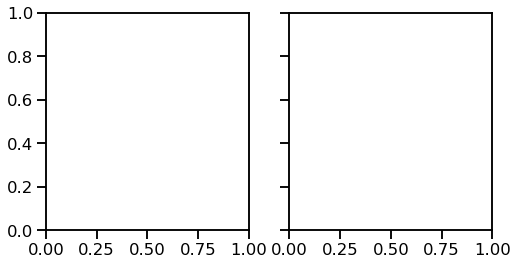

In [17]:
#plot losses
k = 'swingR'
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True); ax=ax.ravel()

for fold in range(len(results[k]['history'])):
    ax[0].plot(results[k]['history'][fold]['loss'])
    ax[1].plot(results[k]['history'][fold]['val_loss'])
ax[0].set_title(k); ax[0].set_ylabel('train loss'); ax[0].set_xlabel('epoch')
ax[1].set_title(k); ax[1].set_ylabel('val loss'); ax[1].set_xlabel('epoch')
plt.tight_layout()
# plt.savefig('./results/Gait/loss_kfold.jpg', dpi=300)
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/loss_kfold.jpg', dpi=300)


IndexError: index 4 is out of bounds for axis 0 with size 4

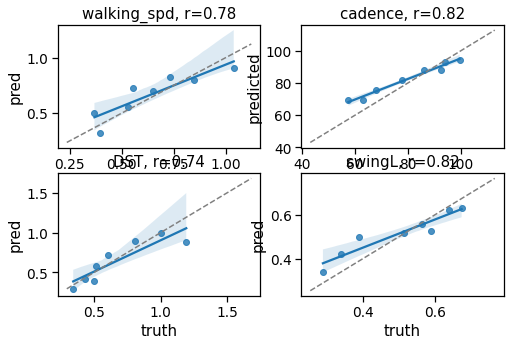

In [27]:
#results for model trained on joint swing/stance
par = ['walking_spd','cadence','DST','swingL','stanceL','swingR','stanceR']

err_df = pd.DataFrame()

#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(2, 2, figsize=(8,5)); ax=ax.ravel()

for i,k in enumerate(par):
    pred = np.concatenate(results[gait_par]['pred'])[:,i]
    true = np.concatenate(results[gait_par]['labels'])[:,i]    
    #rescale
    pred = (yM[i] - ym[i])*(pred + 1)*0.5 + ym[i]
    true = (yM[i] - ym[i])*(true + 1)*0.5 + ym[i]
    videoid = np.concatenate(results[gait_par]['test_group'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_err':pred.squeeze()-true.squeeze()}, index=videoid)), axis=1)
    
    results_df=results_df.groupby(['video_id']).mean() #average across video clips
    sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 
#     ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
    ax[i].plot([ym[i], yM[i]],[ym[i], yM[i]], linestyle='--', c='gray')
    r = str(round(pearsonr(true.squeeze(), pred.squeeze())[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

plt.tight_layout()


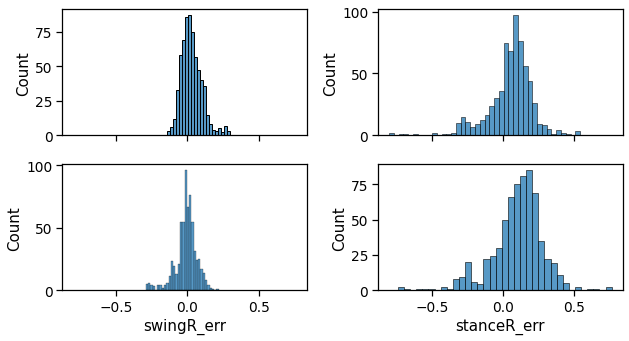

In [32]:
fig, ax = plt.subplots(2,2, figsize=(9,5), sharex=True); ax=ax.ravel()
for i,c in enumerate(err_df.columns):
    sns.histplot(err_df[c], ax=ax[i])
    
plt.tight_layout()
plt.savefig('./results/Gait/err_hist_kfold_swing_stance.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_hist_kfold_swing_stance.jpg', dpi=300)


In [36]:
# err_df.plot(kind='hist', subplots=True, figsize=(8,8), alpha=.8)
# err_df.groupby(err_df.index).mean().plot(kind='hist', subplots=True, figsize=(8,8), alpha=.5, bins=20)

In [ ]:
err_df.groupby(err_df.index).mean().mean(axis=0)
# err_df['swingR_err'].apply(abs).groupby(err_df.index).mean().sort_values(ascending=False)

In [37]:
#save model and history
model_path = './models/Gait/'+gait_par+'_model'
model.save(model_path)
print('saved '+model_path)
np.save(os.path.join(model_path,'history.npy'), history.history)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/Gait/swing_stance_model/assets
saved ./models/Gait/swing_stance_model


In [62]:
results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
results_df

,pred,truth,video_id
6,1.084846,0.739,6
6,1.067800,0.739,6
6,0.953621,0.739,6
6,0.996700,0.739,6
6,1.009085,0.739,6
...,...,...,...
72,1.661484,1.597,72
79,0.924623,0.793,79
79,0.909064,0.793,79
79,0.919750,0.793,79


In [38]:
def rescale_data(data,ym,yM):
    data_res = (yM - ym)*(data + 1)*0.5 + ym
    return data_res


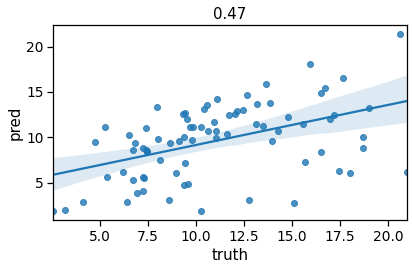

In [45]:
#calculate asymmetry
i = 1
L = rescale_data(np.concatenate(results[gait_par]['labels'])[:,i], ym[i],yM[i])
R = rescale_data(np.concatenate(results[gait_par]['labels'])[:,i+2], ym[i+2],yM[i+2])
asym_swing_true = np.abs((L-R)/(L+R)*100)
L = rescale_data(np.concatenate(results[gait_par]['pred'])[:,i], ym[i],yM[i])
R = rescale_data(np.concatenate(results[gait_par]['pred'])[:,i+2], ym[i+2],yM[i+2])
asym_swing_est = np.abs((L-R)/(L+R)*100)
videoid = videoid.astype(int)
results_df = pd.DataFrame({'pred':asym_swing_est.squeeze(), 'truth':asym_swing_true.squeeze(), 'video_id':videoid}, index=videoid)
results_df=results_df.groupby(['video_id']).mean() #average across video clips
plt.figure()
sns.regplot(data=results_df, x='truth', y='pred')
# plt.plot([xm, xM],[ym, yM], linestyle='--', c='gray')
plt.title(str(round(pearsonr(results_df.truth.values.squeeze(), results_df.pred.values.squeeze())[0],2)))
plt.tight_layout()
plt.savefig('./results/Gait/results_kfold_asymmetry_stance.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_kfold_asymmetry_stance.jpg', dpi=300)


In [44]:
np.save('./results/Gait/results_kfold_200epochs_swing_stance.npy',results, allow_pickle=True)

## Model trained on single parameter (1 output neuron)

These results are the ones presented in the paper

In [60]:
#LOAD results
model_file = 'results_loso_AlphaPose_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee'
results = np.load('./results/'+model_file+'.npy', allow_pickle=True)
results = results.item()

In [61]:
results.keys()

dict_keys(['walking_spd', 'cadence', 'DST', 'swingL', 'stanceL', 'swingR', 'stanceR'])

### Results on Training set
To check underfitting 

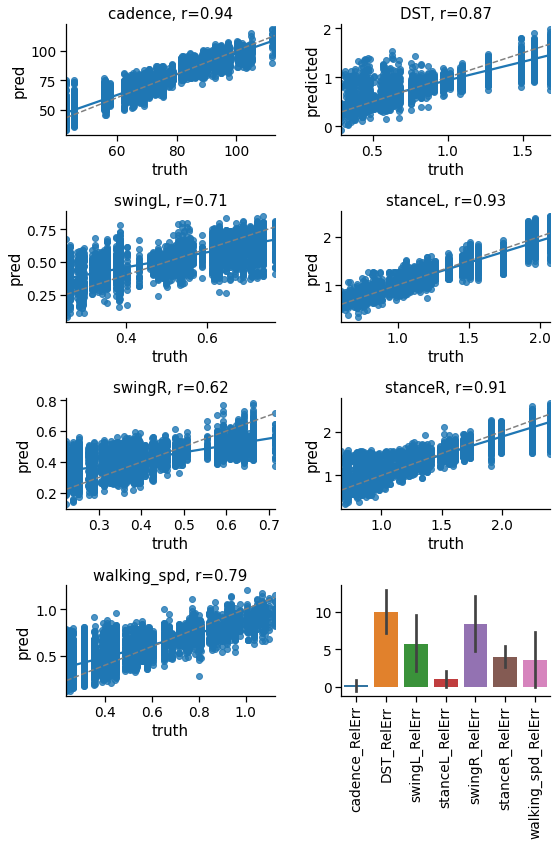

In [89]:
#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(4, 2, figsize=(8,12)); ax=ax.ravel()
err_df = pd.DataFrame(); Results_df = pd.DataFrame()

par = ['cadence','DST','swingL','stanceL','swingR','stanceR','walking_spd']
# par = ['stanceL','stanceR']

# for i,k in enumerate(results.keys()):
for i,k in enumerate(par):
    pred = np.concatenate(results[k]['train']['pred'])
    true = np.concatenate(results[k]['train']['labels'])   
    
    # #rescale targets
    labels = labels_all[k]
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    pred = rescale_data(pred, ym, yM)
    true = rescale_data(true, ym, yM)
    
    videoid = np.concatenate(results[k]['train']['video_id'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    results_df['abs_error'] = pred.squeeze() - true.squeeze() #absolute error
    results_df['rel_error'] = (pred.squeeze() - true.squeeze())/true.squeeze()*100 # percent error
#     results_df=results_df.groupby(['video_id']).median() #average across video clips
    
    err_df = pd.concat((err_df, pd.DataFrame({k+'_AbsErr':results_df['abs_error'].values}, index=results_df.index)), axis=1)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_RelErr':results_df['rel_error'].values}, index=results_df.index)), axis=1)
    
    #aggregate results across all parameters and average by video
    Results_df = pd.concat((Results_df, pd.DataFrame({k+'_pred':pred.squeeze(), k+'_truth':true.squeeze()}, index=videoid)), axis=1)
 
#     sns.regplot(data=results_df.groupby(['video_id']).median(), x='truth', y='pred', ax=ax[i]); 
    sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 
#     ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')

    ax[i].plot([ym, yM],[ym, yM], linestyle='--', c='gray')
    r = str(round(pearsonr(true.squeeze(), pred.squeeze())[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

sns.barplot(data=err_df.groupby(err_df.index).mean()[[c for c in err_df.columns if 'Rel' in c]], ax=ax[-1])
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')

sns.despine()
plt.tight_layout()
# plt.savefig(os.path.join(figs_path, model_file+'Scatter_Train_'+'.jpg'), dpi=300)

<Figure size 432x288 with 0 Axes>

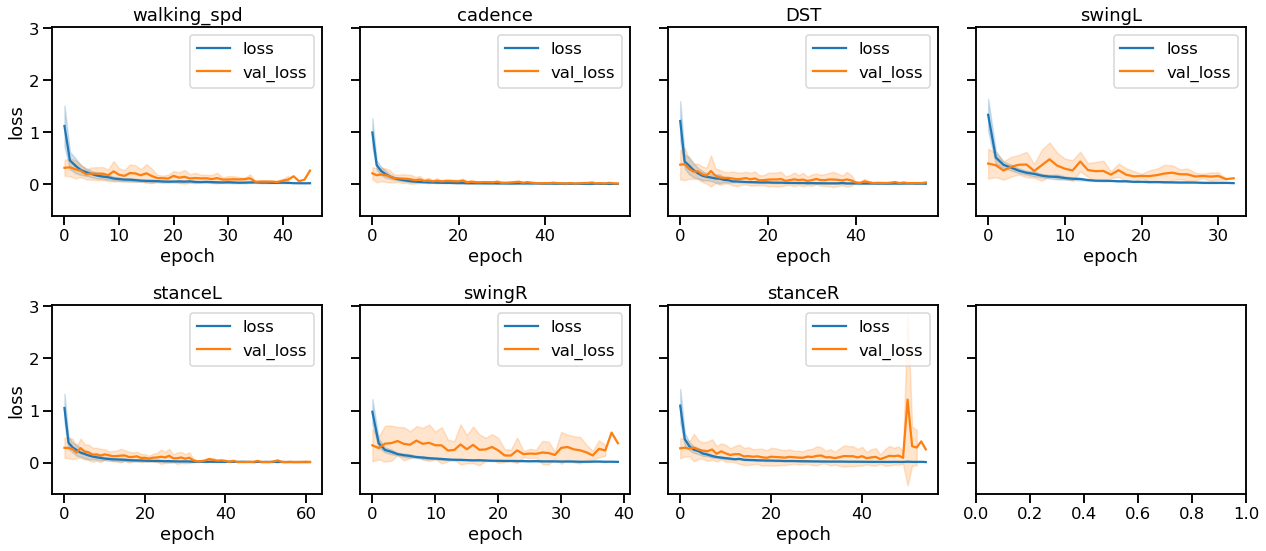

In [91]:
#plot average loss across folds
sns.set_context('talk')
plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(18,8), sharey=True); ax=ax.ravel()
# fig,ax = plt.subplots(1,1);
for i,k in enumerate(results.keys()):
    for loss_name in ['loss','val_loss']:
        loss = pd.DataFrame()
        for fold in range(len(results[k]['history'])):
            loss = pd.concat((loss, results[k]['history'][fold][loss_name]))
        loss.rename(columns={0:loss_name}, inplace=True)
        loss['epoch'] = loss.index.values
        sns.lineplot(data=loss, x='epoch', y=loss_name, ax=ax[i], ci='sd')
        ax[i].set_title(k)
        ax[i].legend(['loss','val_loss'])
plt.tight_layout()
plt.savefig(os.path.join(figs_path,'loss_'+model_file+'.jpg'), dpi=300)


In [40]:
# #plot losses
# sns.set_context('talk')
# fig, ax = plt.subplots(3, 3, figsize=(8,8), sharey=True); ax=ax.ravel()
# l = 'loss'
# for i,k in enumerate(results.keys()):
#     for fold in range(len(results[k]['history'])):
#         ax[i].plot(results[k]['history'][fold][l])
#     ax[i].set_title(k); ax[i].set_ylabel(l); ax[i].set_xlabel('epoch')
        
# plt.tight_layout()
# # plt.savefig('./results/Gait/val_loss_kfold.jpg', dpi=300)
# # plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/val_loss_kfold.jpg', dpi=300)


### Results on left out subjects

results_loso_AlphaPose_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee


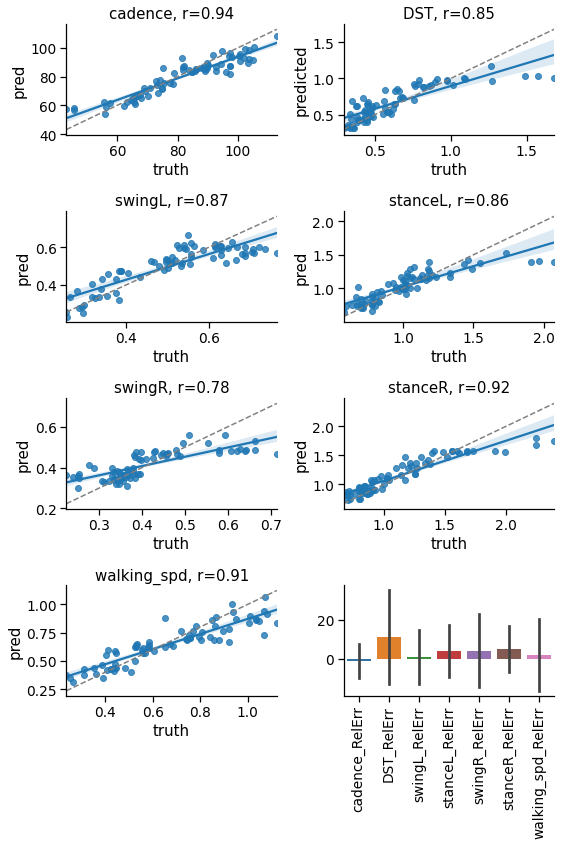

In [62]:
#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(4, 2, figsize=(8,12)); ax=ax.ravel()
err_df = pd.DataFrame(); Results_df = pd.DataFrame()

par = ['cadence','DST','swingL','stanceL','swingR','stanceR','walking_spd']
# par = ['cadence','DST','swingP','stanceP','swingNP','stanceNP','walking_spd']

# for i,k in enumerate(results.keys()):
for i,k in enumerate(par):
    pred = np.concatenate(results[k]['pred'])
    true = np.concatenate(results[k]['labels'])   
    
    # #rescale targets
    labels = labels_all[k]
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    pred = rescale_data(pred, ym, yM)
    true = rescale_data(true, ym, yM)
    
#     videoid = np.concatenate(results[k]['test_group'])
    videoid = np.concatenate(results[k]['video_id'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    results_df['abs_error'] = pred.squeeze() - true.squeeze() #absolute error
    results_df['rel_error'] = (pred.squeeze() - true.squeeze())/true.squeeze()*100 # percent error
    
    #aggregate results across all parameters and average by video
    results_df=results_df.groupby(['video_id']).mean() #average across video clips
    Results_df = pd.concat((Results_df, pd.DataFrame({k+'_pred':pred.squeeze(), k+'_truth':true.squeeze()}, index=videoid)), axis=1)
 
    sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 

    ax[i].plot([ym, yM],[ym, yM], linestyle='--', c='gray')
    r = str(round(pearsonr(results_df['truth'].squeeze(), results_df['pred'].squeeze())[0],2))

    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')
    
    #errors (aggregated across video_id as above)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_AbsErr':results_df['abs_error'].values}, index=results_df.index)), axis=1)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_RelErr':results_df['rel_error'].values}, index=results_df.index)), axis=1)


sns.barplot(data=err_df[[c for c in err_df.columns if 'Rel' in c]], ax=ax[-1], ci='sd')
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(figs_path, model_file+'Scatter_Test_'+'.jpg'), dpi=300)
print(model_file)
    

In [63]:
Results_df

,cadence_pred,cadence_truth,DST_pred,DST_truth,swingL_pred,swingL_truth,stanceL_pred,stanceL_truth,swingR_pred,swingR_truth,stanceR_pred,stanceR_truth,walking_spd_pred,walking_spd_truth
3,67.449753,56.400002,0.981470,1.0955,0.511614,0.387,1.582277,1.734102,0.597493,0.641,1.317179,1.517,0.452301,0.387
3,58.776283,56.400002,0.919763,1.0955,0.395218,0.387,1.495455,1.734102,0.457269,0.641,1.250208,1.517,0.444682,0.387
3,60.595268,56.400002,0.943857,1.0955,0.478695,0.387,1.605809,1.734102,0.513850,0.641,1.755593,1.517,0.446717,0.387
3,54.739510,56.400002,1.053650,1.0955,0.423579,0.387,1.615166,1.734102,0.512510,0.641,1.534701,1.517,0.516113,0.387
3,62.539059,56.400002,1.069431,1.0955,0.398592,0.387,1.229671,1.734102,0.503843,0.641,1.442788,1.517,0.521500,0.387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,94.631470,103.400002,0.433476,0.3360,0.501840,0.500,0.904216,0.684842,0.381680,0.363,0.662044,0.834,0.773802,1.071
62,97.967545,97.300003,0.262423,0.3365,0.564757,0.499,0.785653,0.702143,0.373161,0.391,0.887428,0.842,0.793685,1.080
62,95.676971,97.300003,0.316961,0.3365,0.509182,0.499,0.629375,0.702143,0.419533,0.391,0.938076,0.842,0.887593,1.080
62,101.485451,97.300003,0.414433,0.3365,0.578769,0.499,0.783224,0.702143,0.319364,0.391,0.760882,0.842,0.837824,1.080


In [64]:
#aggregate across clips
# Results_df.head()
Results_df = Results_df.groupby(Results_df.index).mean()
err_df = err_df.groupby(err_df.index).mean()
Results_df = Results_df.join(videoid_map)
err_df = err_df.join(videoid_map)
err_df.set_index('SubjID',inplace=True)
Results_df.set_index('SubjID', inplace=True)

In [65]:
Results_df.head(2)

,cadence_pred,cadence_truth,DST_pred,DST_truth,swingL_pred,swingL_truth,stanceL_pred,stanceL_truth,swingR_pred,swingR_truth,stanceR_pred,stanceR_truth,walking_spd_pred,walking_spd_truth
SubjID,,,,,,,,,,,,,,
SS02_3FU_SSV1_Brace,92.704559,102.000000,0.313587,0.358,0.500626,0.480,0.741039,0.673647,0.378121,0.346,0.918907,0.842,0.839908,1.006
SS02_3FU_SSV3_Brace,95.992996,100.699997,0.361046,0.322,0.479681,0.492,0.753493,0.642098,0.319599,0.345,0.963964,0.793,0.944153,1.069


In [66]:
err_df.head(2)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingL_AbsErr,swingL_RelErr,stanceL_AbsErr,stanceL_RelErr,swingR_AbsErr,swingR_RelErr,stanceR_AbsErr,stanceR_RelErr,walking_spd_AbsErr,walking_spd_RelErr
SubjID,,,,,,,,,,,,,,
SS02_3FU_SSV1_Brace,-9.295437,-9.113173,-0.044413,-12.406001,0.020626,4.297067,0.067392,10.003979,0.032121,9.283564,0.076907,9.133902,-0.166092,-16.510143
SS02_3FU_SSV3_Brace,-4.706999,-4.674279,0.039046,12.126177,-0.012319,-2.503959,0.111395,17.348562,-0.025401,-7.362500,0.170963,21.559080,-0.124847,-11.678826


#### Convert to Paretic (P) and Non-paretic (NP) leg and plot results

In [67]:
metadata = pd.read_csv(os.path.join(datapath,'Metadata.csv'))
metadata.set_index('Filename', inplace=True)
Results_df = pd.merge(metadata, Results_df, left_index=True, right_index=True)
Results_df.rename(columns={'Side captured in video':'Foreground Leg'}, inplace=True)
Results_df.head()

,Paretic Leg,Foreground Leg,cadence_pred,cadence_truth,DST_pred,DST_truth,swingL_pred,swingL_truth,stanceL_pred,stanceL_truth,swingR_pred,swingR_truth,stanceR_pred,stanceR_truth,walking_spd_pred,walking_spd_truth
SS02_3FU_SSV1_Brace,R,R,92.704559,102.000000,0.313587,0.358,0.500626,0.480,0.741039,0.673647,0.378121,0.346,0.918907,0.842,0.839908,1.006
SS02_3FU_SSV1_No Brace,R,R,82.936317,84.800003,0.577788,0.618,0.336522,0.264,1.160137,1.184538,0.471835,0.578,0.827621,0.860,0.554660,0.402
SS02_3FU_SSV2_Brace,R,L,84.483421,81.599998,0.523666,0.477,0.586819,0.586,0.792409,0.831392,0.350379,0.383,1.162793,1.036,0.683989,0.745
SS02_3FU_SSV2_No Brace,R,L,83.477127,84.800003,0.482189,0.472,0.608591,0.564,0.767933,0.780507,0.321213,0.338,1.114455,1.023,0.706026,0.758
SS02_3FU_SSV3_Brace,R,R,95.992996,100.699997,0.361046,0.322,0.479681,0.492,0.753493,0.642098,0.319599,0.345,0.963964,0.793,0.944153,1.069


In [68]:
# Results_df['Foreground Leg'].values
P_L = Results_df.loc[Results_df['Paretic Leg']=="L"][['swingL_pred','swingL_truth', 'stanceL_pred',
                                                     'stanceL_truth']].copy()
P_R = Results_df.loc[Results_df['Paretic Leg']=="R"][['swingR_pred','swingR_truth', 'stanceR_pred',
                                                     'stanceR_truth']].copy()
idx = np.concatenate((P_L.index.values, P_R.index.values), axis=0)
pd.DataFrame(np.vstack((P_L.values, P_R.values)), columns=['swingP_pred','swingP_truth','stanceP_pred',
                                                          'stanceP_truth'], index=idx)


NP_L = Results_df.loc[Results_df['Paretic Leg']=="R"][['swingL_pred','swingL_truth', 'stanceL_pred',
                                                     'stanceL_truth']].copy()
NP_R = Results_df.loc[Results_df['Paretic Leg']=="L"][['swingR_pred','swingR_truth', 'stanceR_pred',
                                                     'stanceR_truth']].copy()
idx = np.concatenate((P_L.index.values, P_R.index.values), axis=0)
dfP = pd.DataFrame(np.vstack((P_L.values, P_R.values)), columns=['swingP_pred','swingP_truth','stanceP_pred',
                                                          'stanceP_truth'], index=idx)
dfNP = pd.DataFrame(np.vstack((NP_L.values, NP_R.values)), columns=['swingNP_pred','swingNP_truth','stanceNP_pred',
                                                          'stanceNP_truth'], index=idx)
dfP_NP = pd.merge(dfP, dfNP, left_index=True, right_index=True)

In [69]:
Results_df_PNP = pd.merge(Results_df[[c for c in Results_df.columns if not( ('swing' in c) or ('stance' in c))]],
        dfP_NP, left_index=True, right_index=True)

In [70]:
Results_df_PNP.head(2)

,Paretic Leg,Foreground Leg,cadence_pred,cadence_truth,DST_pred,DST_truth,walking_spd_pred,walking_spd_truth,swingP_pred,swingP_truth,stanceP_pred,stanceP_truth,swingNP_pred,swingNP_truth,stanceNP_pred,stanceNP_truth
SS02_3FU_SSV1_Brace,R,R,92.704559,102.000000,0.313587,0.358,0.839908,1.006,0.378121,0.346,0.918907,0.842,0.363229,0.223,1.563543,1.684
SS02_3FU_SSV1_No Brace,R,R,82.936317,84.800003,0.577788,0.618,0.554660,0.402,0.471835,0.578,0.827621,0.860,0.467661,0.480,0.749465,0.720


In [71]:
#calc abs and rel errors
err_df_PNP = pd.DataFrame()
par = ['cadence','DST','swingP','stanceP','swingNP','stanceNP','walking_spd']
for i, k in enumerate(par):
    x = k+'_truth'; y =k+'_pred'
    true, pred = Results_df_PNP[x], Results_df_PNP[y]
    err_abs = pred - true
    err_rel = (pred - true)/true*100
    err_df_PNP = pd.concat((err_df_PNP, pd.DataFrame({k+'_AbsErr':err_abs, k+'_RelErr':err_rel}, index=Results_df_PNP.index)), axis=1)

In [72]:
err_df_PNP.head(2)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingP_AbsErr,swingP_RelErr,stanceP_AbsErr,stanceP_RelErr,swingNP_AbsErr,swingNP_RelErr,stanceNP_AbsErr,stanceNP_RelErr,walking_spd_AbsErr,walking_spd_RelErr
SS02_3FU_SSV1_Brace,-9.295441,-9.113177,-0.044413,-12.405999,0.032121,9.283562,0.076907,9.133903,0.140229,62.882961,-0.120457,-7.153010,-0.166092,-16.510143
SS02_3FU_SSV1_No Brace,-1.863686,-2.197742,-0.040212,-6.506792,-0.106165,-18.367670,-0.032379,-3.764997,-0.012339,-2.570674,0.029465,4.092355,0.152660,37.975021


In [73]:
# Results_df_PNP[x], Results_df_PNP[y]
sns.set_context('talk')

In [74]:
#add SubjID
err_df_PNP['subjID'] = err_df_PNP.index
err_df_PNP['subjID'] = err_df_PNP['subjID'].apply(lambda x: x.split('_')[0])

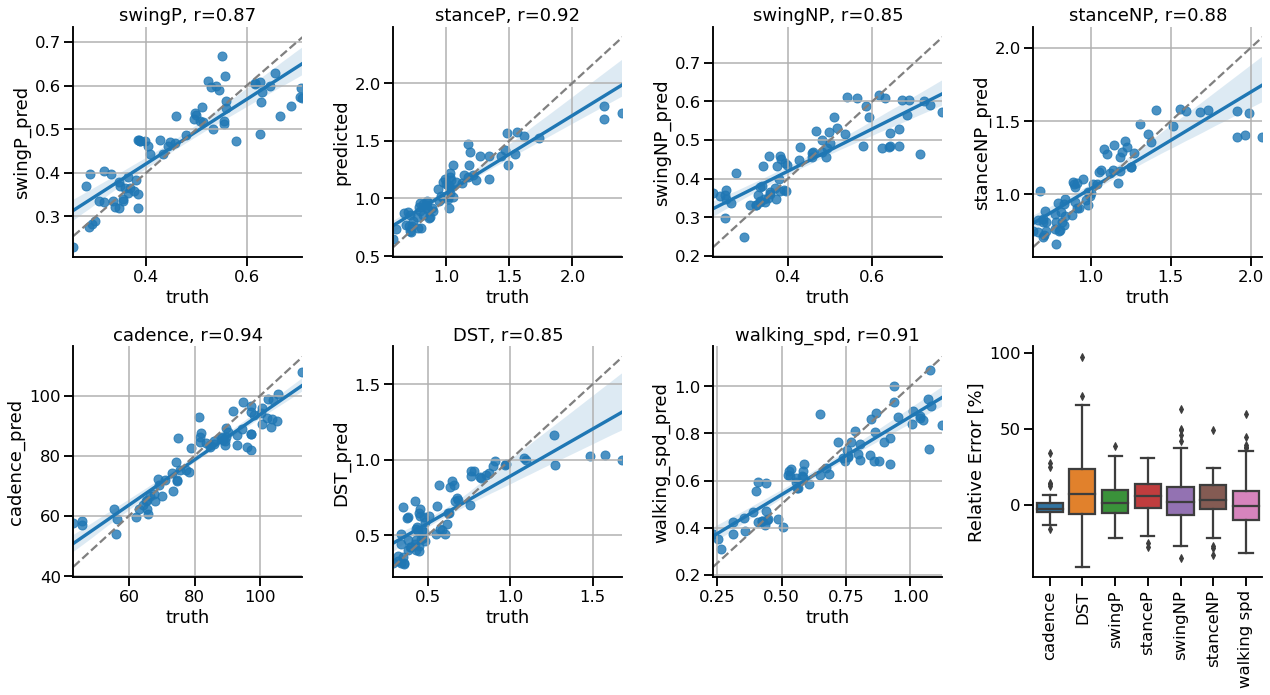

In [75]:
cols = err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]]
new_cols = [x.split('_')[0] for x in err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]].columns.to_list()]
new_cols = {k:v for k,v in zip(cols, new_cols)}
new_cols.update({'walking_spd_RelErr':'walking spd'})

fig, ax = plt.subplots(2,4, figsize=(18,10)); ax=ax.ravel()
par = ['swingP','stanceP','swingNP','stanceNP','cadence','DST','walking_spd']
for i, k in enumerate(par):
    x = k+'_truth'; y =k+'_pred'
    sns.regplot(data=Results_df_PNP, x=x, y=y, ax=ax[i]); 
    xm, xM = Results_df_PNP[x].min(), Results_df_PNP[x].max()
#     ym, yM = Results_df_PNP[y].min(), Results_df_PNP[y].max()
#     ym = np.min([xm, ym]); yM = np.max([xM, yM])
    ax[i].plot([xm, xM],[xm, xM], linestyle='--', c='gray')
    r = str(round(pearsonr(Results_df_PNP[x], Results_df_PNP[y])[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')
    ax[i].grid()
sns.boxplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]].rename(columns=new_cols), ax=ax[-1])
# ax.set_ylabel('Relative Error [%]')
# sns.barplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]], ax=ax[-1], ci='sd')
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')
ax[-1].set_ylabel('Relative Error [%]')
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_corr_2x4'+'.jpg', dpi=300)
# print('saved' + '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_corr'+'.jpg')

In [76]:
err_df_PNP.head()

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingP_AbsErr,swingP_RelErr,stanceP_AbsErr,stanceP_RelErr,swingNP_AbsErr,swingNP_RelErr,stanceNP_AbsErr,stanceNP_RelErr,walking_spd_AbsErr,walking_spd_RelErr,subjID
SS02_3FU_SSV1_Brace,-9.295441,-9.113177,-0.044413,-12.405999,0.032121,9.283562,0.076907,9.133903,0.140229,62.882961,-0.120457,-7.153010,-0.166092,-16.510143,SS02
SS02_3FU_SSV1_No Brace,-1.863686,-2.197742,-0.040212,-6.506792,-0.106165,-18.367670,-0.032379,-3.764997,-0.012339,-2.570674,0.029465,4.092355,0.152660,37.975021,SS02
SS02_3FU_SSV2_Brace,2.883423,3.533607,0.046666,9.783272,-0.032621,-8.517169,0.126793,12.238732,0.009174,2.840152,-0.096983,-8.274986,-0.061011,-8.189390,SS02
SS02_3FU_SSV2_No Brace,-1.322876,-1.559995,0.010189,2.158736,-0.016787,-4.966425,0.091455,8.939904,-0.002583,-0.733916,0.011358,1.135778,-0.051974,-6.856696,SS02
SS02_3FU_SSV3_Brace,-4.707001,-4.674281,0.039046,12.126178,-0.025401,-7.362495,0.170964,21.559084,0.050606,9.961884,0.106719,12.842284,-0.124847,-11.678824,SS02


## Error tables and error analysis

In [77]:
#calculate asymmetry
def calc_asymmetry(L,R):
    return (L-R)/(0.5*(L+R))

#plot asymmetry errors
asym_swing_pred = calc_asymmetry(Results_df['swingL_pred'], Results_df['swingR_pred'])
asym_swing_true = calc_asymmetry(Results_df['swingL_truth'], Results_df['swingR_truth'])
asym_stance_pred = calc_asymmetry(Results_df['stanceL_pred'], Results_df['stanceR_pred'])
asym_stance_true = calc_asymmetry(Results_df['stanceL_truth'], Results_df['stanceR_truth'])
asym_df = pd.DataFrame({'asym_swing_pred':asym_swing_pred, 'asym_swing_truth':asym_swing_true, 
                        'asym_stance_pred':asym_stance_pred, 'asym_stance_truth':asym_stance_true}, 
                      index=Results_df.index)

Results_df = pd.concat((Results_df, asym_df), axis=1)

In [78]:
Results_df.shape

(70, 20)

In [79]:
#DISTRIBUTION OF TRUE VALUES FROM GAITRITE
true_vals = Results_df_PNP[[c for c in Results_df_PNP.columns if 'truth' in c]]
true_mean = true_vals.mean()
true_median = true_vals.median()
true_sd = true_vals.std()
true_95ci_q1 = true_vals.quantile(q=0.025)
true_95ci_q2 = true_vals.quantile(q=0.975)
true_min, true_max = true_vals.min(), true_vals.max()
# true_table = pd.DataFrame([true_mean, true_median, true_95ci_q1, true_95ci_q2], index=['Mean','Median','2.5q','97.5q'])
true_table = pd.DataFrame([true_mean, true_sd, true_min, true_max], index=['Mean','SD','min','max'])
true_table = true_table.apply(round, args=(2,))
true_table['cadence_truth'] = true_table['cadence_truth'].apply(round, args=(1,))
true_table.T.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/truthpar_stats.csv')
true_table.T

,Mean,SD,min,max
cadence_truth,82.00,16.20,43.10,112.90
DST_truth,0.62,0.31,0.29,1.68
walking_spd_truth,0.68,0.24,0.24,1.12
swingP_truth,0.46,0.13,0.26,0.71
stanceP_truth,1.06,0.37,0.58,2.40
swingNP_truth,0.45,0.15,0.22,0.77
stanceNP_truth,1.08,0.36,0.64,2.07


In [80]:
#DISTRIBUTION OF ERRORS
err_mu = err_df_PNP.mean()
err_median = err_df_PNP.median()
# err_iqr = errs_df.quantile(q=0.75) - errs_df.quantile(q=0.25)
err_95ci = err_df_PNP.quantile(q=0.975) - err_df_PNP.quantile(q=0.025)
err_sd = err_df_PNP.std()
errtable = pd.DataFrame([err_mu, err_median, err_sd], index=['Mean','Median', 'SD']).T.apply(round, args=(2,))
err_table_abs = errtable.loc[ [c for c in err_df_PNP.columns if 'Abs' in c]].apply(round, args=(2,)).copy()
newcols = zip(err_table_abs.index, [c.split('_')[0] for c in err_table_abs.index])
err_table_abs.rename(index=dict(newcols), inplace=True)
errtable.loc[ [c for c in err_df_PNP.columns if 'Abs' in c]].apply(round, args=(2,))

,Mean,Median,SD
cadence_AbsErr,-1.84,-2.12,6.04
DST_AbsErr,0.03,0.04,0.17
swingP_AbsErr,0.00,0.01,0.06
stanceP_AbsErr,0.03,0.06,0.16
swingNP_AbsErr,-0.00,0.01,0.08
stanceNP_AbsErr,0.01,0.03,0.17
walking_spd_AbsErr,-0.02,-0.01,0.11


In [81]:
err_table_rel = errtable.loc[[c for c in err_df_PNP.columns if 'Rel' in c]].iloc[:,0:3].apply(round, args=(1,))
newcols = zip(err_table_rel.index, [c.split('_')[0] for c in err_table_rel.index])
err_table_rel.rename(index=dict(newcols), inplace=True)
errtable.loc[[c for c in err_df_PNP.columns if 'Rel' in c]].iloc[:,0:3].apply(round, args=(1,))

,Mean,Median,SD
cadence_RelErr,-1.2,-2.6,8.700000
DST_RelErr,11.2,7.2,24.299999
swingP_RelErr,2.7,1.6,13.100000
stanceP_RelErr,5.4,5.8,11.900000
swingNP_RelErr,3.5,2.0,19.200001
stanceNP_RelErr,4.0,3.1,13.300000
walking_spd_RelErr,1.8,-0.6,18.299999


In [82]:
#create a single table
err_table2 = pd.concat((err_table_rel, err_table_abs), axis=1)
err_table2

,Mean,Median,SD,Mean,Median,SD
cadence,-1.2,-2.6,8.700000,-1.84,-2.12,6.04
DST,11.2,7.2,24.299999,0.03,0.04,0.17
swingP,2.7,1.6,13.100000,0.00,0.01,0.06
stanceP,5.4,5.8,11.900000,0.03,0.06,0.16
swingNP,3.5,2.0,19.200001,-0.00,0.01,0.08
stanceNP,4.0,3.1,13.300000,0.01,0.03,0.17
walking,1.8,-0.6,18.299999,-0.02,-0.01,0.11


In [83]:
err_table2.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_absrel_stats__AlphaPose_'+model_file+'.csv')

In [54]:
# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
# ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
# plt.tight_layout()


In [47]:
err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]]

,cadence_AbsErr,DST_AbsErr,swingP_AbsErr,stanceP_AbsErr,swingNP_AbsErr,stanceNP_AbsErr,walking_spd_AbsErr
SS02_3FU_SSV1_Brace,-9.295441,-0.044413,0.032121,0.076907,0.140229,-0.120457,-0.166092
SS02_3FU_SSV1_No Brace,-1.863686,-0.040212,-0.106165,-0.032379,-0.012339,0.029465,0.152660
SS02_3FU_SSV2_Brace,2.883423,0.046666,-0.032621,0.126793,0.009174,-0.096983,-0.061011
SS02_3FU_SSV2_No Brace,-1.322876,0.010189,-0.016787,0.091455,-0.002583,0.011358,-0.051974
SS02_3FU_SSV3_Brace,-4.707001,0.039046,-0.025401,0.170964,0.050606,0.106719,-0.124847
...,...,...,...,...,...,...,...
SS22_Post_SSV1_No Brace,-3.644356,0.184482,0.059265,0.179289,-0.024438,0.144393,0.052747
SS22_Post_SSV2_Brace,-2.624710,-0.044871,-0.031670,0.004971,0.094482,0.152943,-0.113880
SS22_Post_SSV2_No Brace,-4.879417,0.102938,0.070505,0.065294,-0.013103,-0.063833,-0.006552
SS22_Post_SSV3_Brace,-2.094795,0.266354,0.087946,0.157026,-0.133564,-0.066378,-0.019881


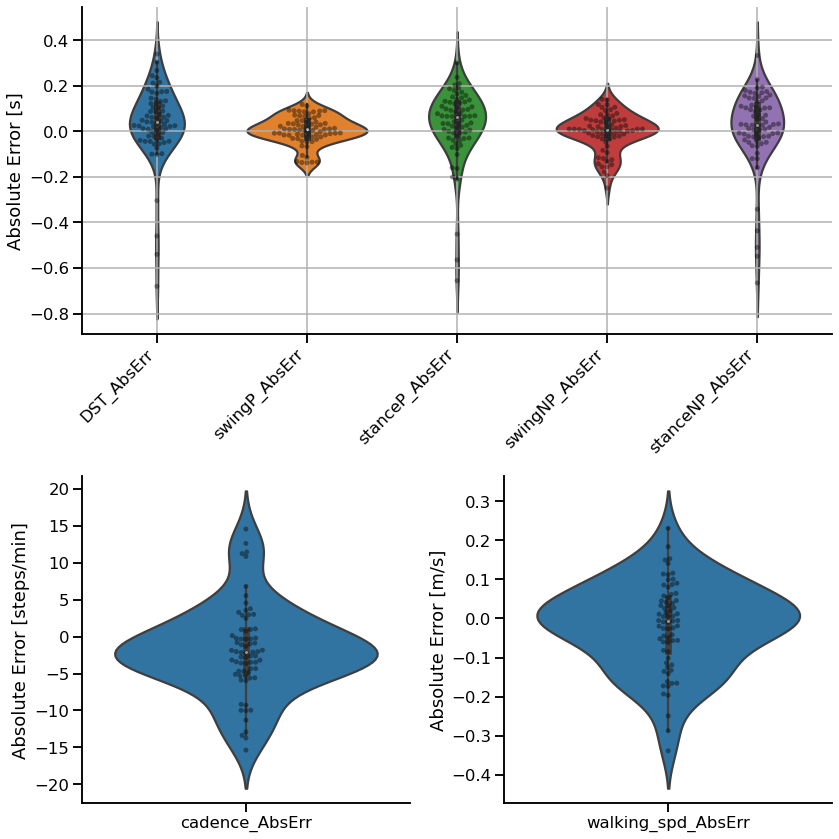

In [48]:
#ABSOLUTE ERRORS
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, fig=fig)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, fig=fig)
plt.tight_layout()

ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,1:-1], ax=ax1)
sns.swarmplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,1:-1], color='black', alpha=.4, ax=ax1)
ax1.set_ylabel('Absolute Error [s]')
ax.grid()
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,0:1], ax=ax2)
ax2.set_ylabel('Absolute Error [steps/min]')
sns.swarmplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,0:1], color='black', alpha=.4, ax=ax2)
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,-1:], ax=ax3)
ax = sns.swarmplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,-1:], color='black', alpha=.4, ax=ax3)
ax3.set_ylabel('Absolute Error [m/s]')
plt.tight_layout()
sns.despine()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_ErrAbs_Violinplot'+'.jpg', dpi=300)

/home/l_lonini01/anaconda3/envs/tf2_4-gpu/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


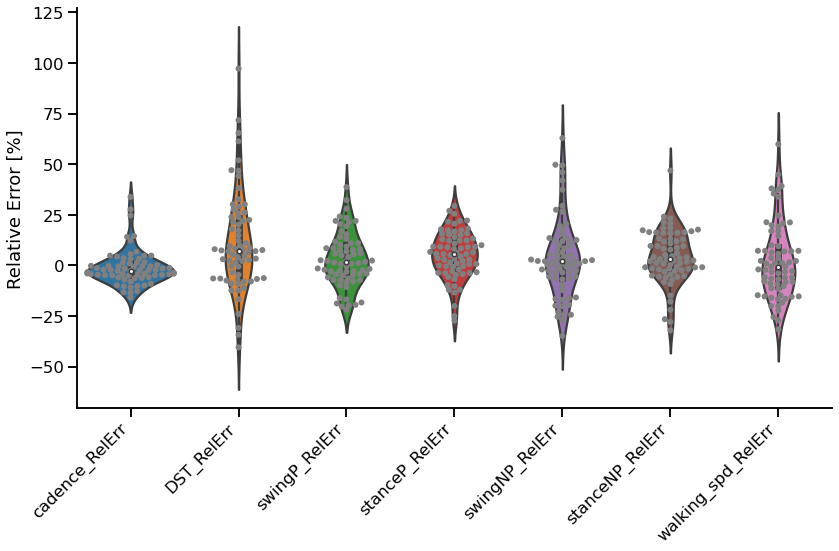

In [64]:
#RELATIVE ERRORS
plt.figure(figsize=(12,8))
# ax = sns.boxplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]])
sns.swarmplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c or 'ID' in c]], color='gray', size=6)
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]])
ax.set_ylabel('Relative Error [%]')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
sns.despine()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_ErrRel_Violinplot'+'.jpg', dpi=300)

# Other Analysis not presented in the paper

### Pre-Post session analysis

In [52]:
def time_condition(x):
    if 'Pre' in x:
        return 'Pre'
    if 'Mid' in x:
        return 'Mid'
    elif 'Post' in x:
        return 'Post'
    else:
        return 'None'

def brace_condition(x):    
    if '_No Brace' in x:
        return 'No Brace'
    elif '_Brace' in x:
        return 'Brace'
    else:
        return 'None'

In [53]:
changes = Results_df_PNP.copy()
changes['VideoID'] = changes.index.values
changes['TimePoint'] = changes['VideoID'].apply(time_condition)
changes['Device'] = changes['VideoID'].apply(brace_condition)
changes['SubjID'] = changes['VideoID'].apply(lambda x:x.split('_')[0])
#modify Mid with Pre
changes.loc[changes['TimePoint']=="Mid",'TimePoint'] = 'Pre'
changes = changes.groupby(['SubjID','TimePoint','Device']).mean()
changes.head()

cadence_pred  cadence_truth  DST_pred  DST_truth  \
SubjID TimePoint Device                                                       
SS02   None      Brace        91.060326      94.766663  0.399433   0.385667   
                 No Brace     85.265198      86.400002  0.486002   0.512667   
SS04   Post      Brace        70.864555      73.233330  0.813443   0.789333   
                 No Brace     69.434387      73.099998  0.813064   0.847000   
       Pre       Brace        89.889252      86.000000  0.537994   0.455833   

                           walking_spd_pred  walking_spd_truth  swingP_pred  \
SubjID TimePoint Device                                                       
SS02   None      Brace             0.822683           0.940000     0.349367   
                 No Brace          0.688860           0.674000     0.394796   
SS04   Post      Brace             0.487877           0.481333     0.479928   
                 No Brace          0.502186           0.508667     0.583719   
       Pre       Brace             0.722603           0.803333     0.426790   

                           swingP_truth  stanceP_pred  stanceP_truth  \
SubjID TimePoint Device                                                
SS02   None      Brace         0.358000      1.015221       0.890333   
                 No Brace      0.426667      1.026753       0.952667   
SS04   Post      Brace         0.465667      1.207304       1.252333   
                 No Brace      0.606667      1.052241       1.119333   
       Pre       Brace         0.440667      1.046835       0.968000   

                           swingNP_pred  swingNP_truth  stanceNP_pred  \
SubjID TimePoint Device                                                 
SS02   None      Brace         0.418003       0.351333       1.192093   
                 No Brace      0.419176       0.408000       1.080527   
SS04   Post      Brace         0.524050       0.485333       0.853954   
                 No Brace      0.505209       0.501000       0.942556   
       Pre       Brace         0.474656       0.443333       0.918313   

                           stanceNP_truth  
SubjID TimePoint Device                    
SS02   None      Brace           1.229000  
                 No Brace        1.009000  
SS04   Post      Brace           0.880667  
                 No Brace        0.868333  
       Pre       Brace           0.917000

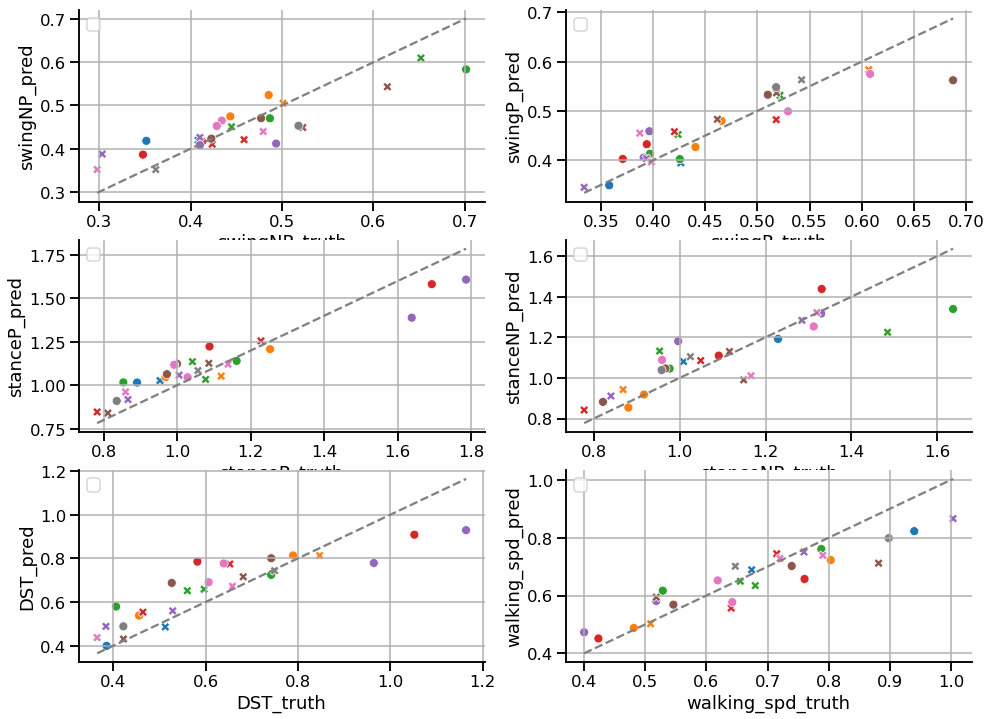

In [54]:
fig, ax = plt.subplots(3,2, figsize=(16,12)); ax=ax.ravel()
for i,par in enumerate(['swingNP', 'swingP','stanceP','stanceNP','DST','walking_spd']):
    sns.scatterplot(data=changes, x=par+'_truth', y=par+'_pred', hue='SubjID', style='Device', ax=ax[i])
    xm, xM = changes[par+'_truth'].min(), changes[par+'_truth'].max()
    ax[i].plot([xm, xM],[xm, xM], linestyle='--', c='gray')
    ax[i].grid()
    ax[i].legend([])
    
sns.despine()

In [55]:
Delta = []
for d in ['Brace', 'No Brace']:
    pre = changes.loc[(slice(None),'Pre', d)]
    post = changes.loc[(slice(None),'Post', d)]
    delta = (post-pre)
    delta['Device'] = d
    delta.dropna(inplace=True)
    Delta.append(delta)
Delta = pd.concat(Delta)

In [56]:
Delta

,cadence_pred,cadence_truth,DST_pred,DST_truth,walking_spd_pred,walking_spd_truth,swingP_pred,swingP_truth,stanceP_pred,stanceP_truth,swingNP_pred,swingNP_truth,stanceNP_pred,stanceNP_truth,Device
SubjID,,,,,,,,,,,,,,,
SS04,-19.024696,-12.766670,0.275449,0.333500,-0.234726,-0.322000,0.053138,0.025000,0.160469,0.284333,0.049395,0.042000,-0.064359,-0.036333,Brace
SS06,8.169754,14.916672,-0.145186,-0.335750,0.144049,0.259333,0.010797,-0.028667,-0.123650,-0.308333,0.113247,0.214833,0.293492,0.659833,Brace
SS07,17.172421,24.066662,-0.123411,-0.469750,0.205839,0.337167,0.029845,0.023000,-0.358516,-0.605167,0.030044,0.064833,-0.328048,-0.239667,Brace
SS13,-10.990158,-4.650002,0.150468,0.199750,-0.108254,-0.118000,0.053449,0.005500,0.219396,0.148000,0.003576,0.083500,0.136155,0.333000,Brace
SS18,-3.859573,-7.799995,0.112968,0.215250,-0.133689,-0.193500,0.029394,0.177500,0.060122,0.027500,0.047380,0.054500,0.164586,0.145500,Brace
SS20,-0.885239,6.199997,-0.086021,-0.032750,-0.075099,0.023833,-0.075741,-0.078667,0.071925,-0.036667,0.012495,0.005500,0.164482,0.353000,Brace
SS06,-1.261314,-5.666664,0.006636,0.036333,-0.014813,0.024500,0.079610,0.097667,-0.102307,0.036000,-0.159275,-0.207333,-0.092489,-0.530667,No Brace
SS07,-14.985146,-17.633339,0.220298,0.188167,-0.188049,-0.074500,-0.024349,-0.097500,0.409288,0.445833,-0.010521,-0.034833,0.243504,0.271333,No Brace
SS13,11.838249,14.200005,-0.071034,-0.144583,0.115717,0.243833,-0.058201,-0.059667,-0.140836,-0.139167,0.038591,0.107000,-0.372694,-0.444667,No Brace


In [57]:
#calc abs and rel errors
err_Delta = pd.DataFrame()
par = ['cadence','DST','swingP','stanceP','swingNP','stanceNP','walking_spd']
for i, k in enumerate(par):
    x = k+'_truth'; y =k+'_pred'
    true, pred = Delta[x],Delta[y]
    err_abs = pred - true
    err_rel = (pred - true)/true*100
    err_Delta = pd.concat((err_Delta, pd.DataFrame({k+'_AbsErr':err_abs, k+'_RelErr':err_rel}, index=Delta.index)), axis=1)

In [58]:
err_Delta['Device'] = Delta['Device']
# sns.boxplot(data=err_Delta, x='Device')
err_Delta

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingP_AbsErr,swingP_RelErr,stanceP_AbsErr,stanceP_RelErr,swingNP_AbsErr,swingNP_RelErr,stanceNP_AbsErr,stanceNP_RelErr,walking_spd_AbsErr,walking_spd_RelErr,Device
SubjID,,,,,,,,,,,,,,,
SS04,-6.258026,49.018467,-0.058051,-17.406673,0.028138,112.550568,-0.123864,-43.563068,0.007395,17.606421,-0.028026,77.134445,0.087274,-27.103645,Brace
SS06,-6.746918,-45.230717,0.190564,-56.757648,0.039464,-137.663651,0.184683,-59.897240,-0.101587,-47.286293,-0.366341,-55.520309,-0.115284,-44.453953,Brace
SS07,-6.894241,-28.646439,0.346339,-73.728432,0.006845,29.762152,0.246650,-40.757423,-0.034790,-53.660236,-0.088382,36.876850,-0.131328,-38.950329,Brace
SS13,-6.340157,136.347412,-0.049282,-24.671898,0.047949,871.804810,0.071396,48.240776,-0.079924,-95.717888,-0.196845,-59.112675,0.009746,-8.259663,Brace
SS18,3.940422,-50.518261,-0.102282,-47.517929,-0.148106,-83.440186,0.032622,118.626534,-0.007120,-13.064186,0.019086,13.117194,0.059811,-30.910162,Brace
SS20,-7.085236,-114.278053,-0.053271,162.659485,0.002925,-3.718799,0.108592,-296.160370,0.006995,127.186821,-0.188518,-53.404575,-0.098932,-415.098663,Brace
SS06,4.405350,-77.741501,-0.029697,-81.735542,-0.018056,-18.487564,-0.138307,-384.185577,0.048059,-23.179487,0.438178,-82.571213,-0.039313,-160.461609,No Brace
SS07,2.648193,-15.018106,0.032131,17.076054,0.073151,-75.026634,-0.036546,-8.197179,0.024313,-69.796791,-0.027829,-10.256360,-0.113549,152.414352,No Brace
SS13,-2.361755,-16.632074,0.073549,-50.869942,0.001466,-2.457042,-0.001670,1.199659,-0.068409,-63.933479,0.071973,-16.185772,-0.128116,-52.542641,No Brace


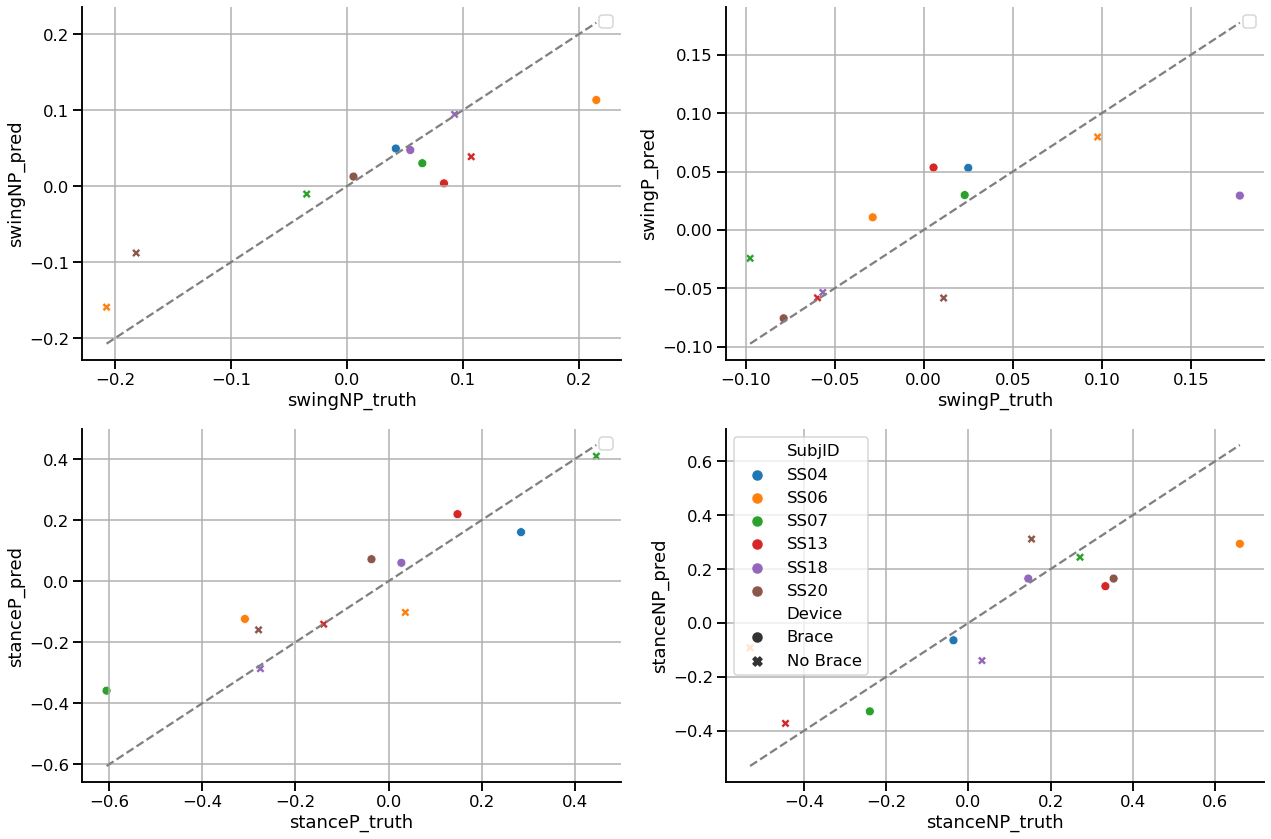

In [59]:
fig, ax = plt.subplots(2,2, figsize=(18,12)); ax=ax.ravel()
for i,par in enumerate(['swingNP', 'swingP','stanceP','stanceNP']):
    sns.scatterplot(data=Delta, x=par+'_truth', y=par+'_pred', hue='SubjID', style='Device', ax=ax[i])
    xm, xM = Delta[par+'_truth'].min(), Delta[par+'_truth'].max()
    ax[i].plot([xm, xM],[xm, xM], linestyle='--', c='gray')
    ax[i].grid()
    ax[i].legend([])
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_Changes'+'.jpg', dpi=300)

In [142]:
Delta
# sns.boxplot(data=Delta, x='Device', y=)

,cadence_pred,cadence_truth,DST_pred,DST_truth,walking_spd_pred,walking_spd_truth,swingP_pred,swingP_truth,stanceP_pred,stanceP_truth,swingNP_pred,swingNP_truth,stanceNP_pred,stanceNP_truth,Device
SubjID,,,,,,,,,,,,,,,
SS04,5.950951,5.566666,-0.109478,-0.129500,0.091328,0.096000,-0.022437,-0.011333,-0.149075,-0.101333,-0.113027,-0.128000,-0.425383,-0.376667,Brace
SS06,4.037918,10.066666,-0.025539,-0.092500,0.070856,0.196333,-0.018623,0.005667,0.041039,-0.129333,0.008012,0.056667,-0.104854,-0.089667,Brace
SS07,-5.547974,-9.783333,0.055995,0.011167,-0.100441,-0.040000,0.052360,0.065833,0.134396,0.079833,0.022479,-0.023667,-0.112703,-0.071667,Brace
SS13,2.874886,1.483337,-0.022203,-0.025750,0.072247,0.065500,-0.004370,-0.018833,-0.016202,-0.019333,-0.023081,0.001000,-0.003625,0.032667,Brace
SS18,-5.472466,-5.866669,0.071145,0.150000,-0.055099,-0.085000,-0.011701,0.011000,0.145225,0.158333,0.084740,0.066000,1.053006,1.471333,Brace
SS20,0.829865,4.533333,-0.062154,-0.013833,0.018113,0.039667,-0.038570,-0.013333,0.010436,-0.026333,-0.015334,0.019000,0.125390,0.070667,Brace
SS06,-8.800186,-7.583328,0.080953,0.029250,-0.123620,-0.004000,0.026257,0.105833,0.086048,0.054833,-0.066981,0.038500,0.062847,0.047833,No Brace
SS07,2.436073,0.016663,-0.054914,-0.134583,0.031952,0.114333,0.051658,0.057000,-0.085752,-0.087500,-0.008236,0.014500,0.122039,0.130500,No Brace
SS13,8.664215,7.233330,-0.031668,-0.063500,0.105922,0.078500,-0.018130,-0.016833,-0.059519,-0.113000,-0.002031,0.047667,-0.056156,-0.027500,No Brace


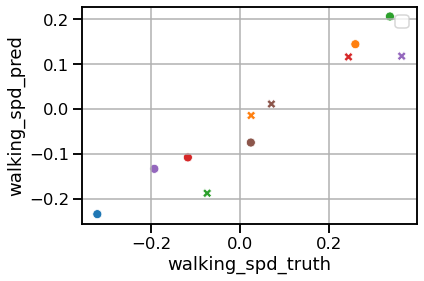

In [62]:
sns.scatterplot(data=Delta, x='walking_spd_truth', y='walking_spd_pred', hue='SubjID', style='Device')
xm, xM = Delta['walking_spd_truth'].min(), Delta['walking_spd_truth'].max()
plt.legend([])
plt.grid()

<AxesSubplot:xlabel='walking_spd_truth', ylabel='walking_spd_pred'>

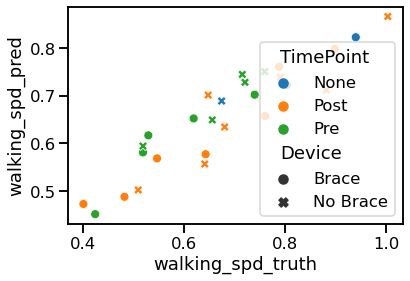

In [63]:
sns.scatterplot(data=changes, x='walking_spd_truth', y='walking_spd_pred', hue='TimePoint', style='Device')



<AxesSubplot:xlabel='SubjID', ylabel='stanceNP_truth'>

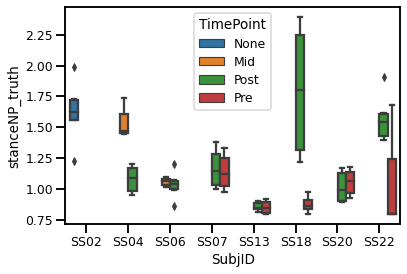

In [86]:
sns.boxplot(data=changes, x='SubjID', y='stanceNP_truth', hue='TimePoint')

In [297]:
# #condense L and R into a single column
# L = Results_df[['swingL_pred','swingL_truth','stanceL_pred','stanceL_truth']].copy()
# R = Results_df[['swingR_pred','swingR_truth','stanceR_pred','stanceR_truth']].copy()
# idx = np.concatenate((L.index.values, R.index.values), axis=0)
# swst = pd.DataFrame(np.vstack((L.values, R.values)), columns=['swing_pred','swing_truth','stance_pred','stance_truth'], index=idx)
# sns.regplot(swst['stance_truth'], swst['stance_pred'])

In [71]:
Results_df.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/resultsdf_walkspd_mean.csv')

### Bland-Altman plots

In [69]:
def bland_altman_plot(data1, data2, ax, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    ax.scatter(mean, diff, *args, **kwargs)
    ax.axhline(md,           color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--')
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--')
    ax.annotate(f'mean diff:\n{np.round(md+1E-5, 2)}',
            xy=(0.99, 0.5),
            horizontalalignment='right',
            verticalalignment='center',
            fontsize=12,
            xycoords='axes fraction')


saved /home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_loso_AlphaPose_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_BAPlot.jpg


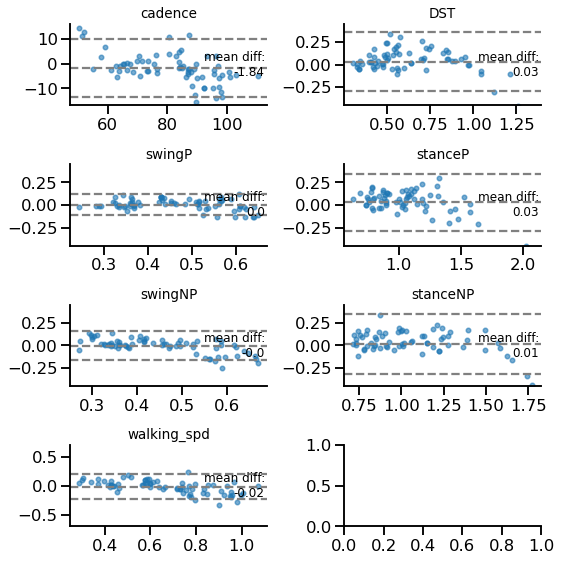

In [70]:
#bland altman plots
par = ['cadence','DST','swingL','stanceL','swingR','stanceR','walking_spd']
par = ['cadence','DST','swingP','stanceP','swingNP','stanceNP','walking_spd']

fig, ax = plt.subplots(4, 2, figsize=(8,8)); ax=ax.ravel()
sns.set_context('talk', font_scale=0.75)
for i,k in enumerate(par):
    ax[i].set_title(f'{k}')
    bland_altman_plot(Results_df_PNP[k+'_pred'],Results_df_PNP[k+'_truth'],ax[i], s=20, alpha=0.6)
    if i > 0 and i < 6:
        ax[i].set_ylim([-.45, .45])
    if i > 5:
        ax[i].set_ylim([-.7, .7])
#     sm.graphics.mean_diff_plot(Results_df[k+'_pred'],Results_df[k+'_truth'], ax=ax[i], 
#                                mean_line_kwds={'color':'gray'})
sns.despine()
plt.tight_layout()
print('saved '+'/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_BAPlot'+'.jpg')
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_BAPlot'+'.jpg', dpi=300)

### Correlation of errrors and individual subject errors

<AxesSubplot:>

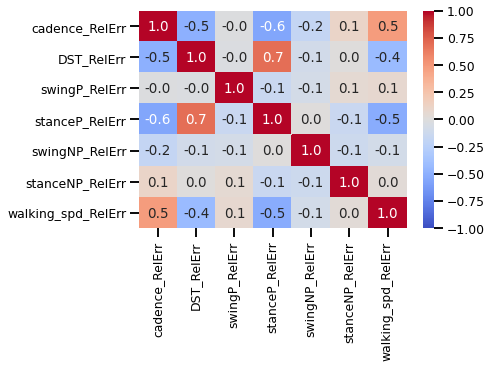

In [71]:
sns.heatmap(err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]].corr(), vmin=-1.0, vmax=1.0,
           cmap='coolwarm', annot=True, fmt='.1f')

SS22_Pre_SSV1_No Brace     23.236301
SS18_Post_SSV1_No Brace    15.536819
SS18_Post_SSV3_No Brace    13.801596
SS18_Pre_SSV2_No Brace     13.233908
SS04_Post_SSV2_No Brace    12.209604
Name: stanceNP_RelErr, dtype: float32


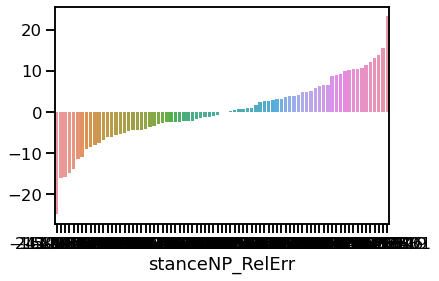

In [57]:
k = 'stanceNP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS22_Pre_SSV3_No Brace    113.103363
SS02_3FU_SSV1_No Brace     71.564964
SS02_3FU_SSV2_No Brace     63.209637
SS22_Post_SSV1_Brace       60.341072
SS04_Post_SSV2_Brace       51.943619
Name: swingNP_RelErr, dtype: float32


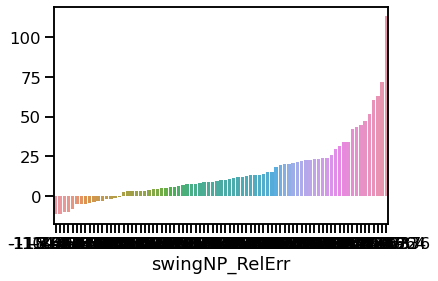

In [58]:
k = 'swingNP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS22_Pre_SSV3_No Brace    0.252221
SS02_3FU_SSV1_No Brace    0.170325
SS06_Mid_SSV2_No Brace    0.166407
SS02_3FU_SSV2_No Brace    0.159920
SS22_Post_SSV1_Brace      0.151456
Name: swingNP_AbsErr, dtype: float32


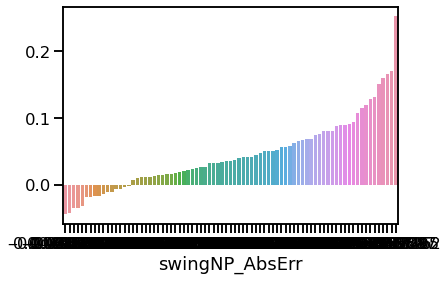

In [59]:
k = 'swingNP_AbsErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS18_Post_SSV1_No Brace    0.203066
SS22_Pre_SSV1_No Brace     0.184961
SS18_Post_SSV3_No Brace    0.167965
SS22_Post_SSV1_No Brace    0.150813
SS22_Post_SSV2_No Brace    0.125926
Name: stanceNP_AbsErr, dtype: float32


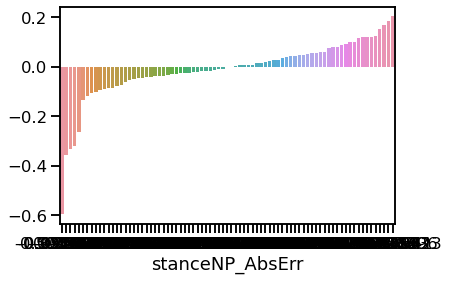

In [60]:
k = 'stanceNP_AbsErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS20_Pre_SSV1_No Brace    19.467796
SS04_Mid_SSV2_Brace       15.371947
SS06_Mid_SSV1_Brace       14.995644
SS06_Mid_SSV2_Brace       13.894774
SS06_Post_SSV2_Brace      12.424361
Name: swingP_RelErr, dtype: float32


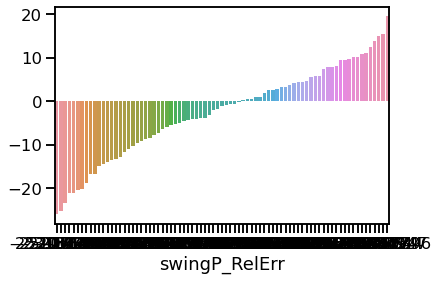

In [179]:
k = 'swingP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS06_Post_SSV3_Brace    49.321896
SS07_Post_SSV2_Brace    18.899349
SS13_Post_SSV3_Brace    18.414408
SS07_Post_SSV1_Brace    16.805000
SS07_Pre_SSV1_Brace     15.806360
Name: stanceP_RelErr, dtype: float32


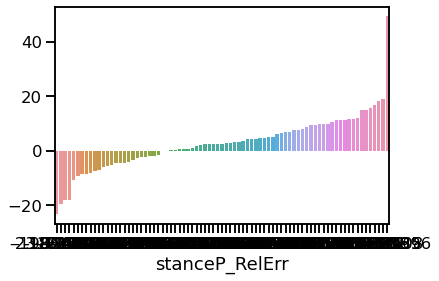

In [177]:
k = 'stanceP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:5] 
print(top5[:5])
plt.figure()
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

In [75]:
top5.index.values
print(videoid_map.loc[videoid_map['SubjID']==top5.index[0]])

                SubjID
1  SS02_3FU_SSV3_Brace


In [165]:
videoid_map.loc[75]

SubjID    SS13_Post_SSV3_Brace
Name: 75, dtype: object

In [61]:
#plot key point series for high errors
err_idx=(videoid_map.loc[videoid_map['SubjID']==top5.index[0]].index.values.squeeze())
print(err_idx)
inds_err = np.argwhere(labels_all['videoId'] == err_idx).squeeze()
print(inds_err)
data_err = data[inds_err]
for i in range(len(data_err)):
    plt.figure()
    plt.plot(data_err[i])

49


KeyError: 'videoId'

In [373]:
err_idx

#### Check against manual video annotations

In [ ]:
# Results_df.set_index('SubjID', inplace=True)

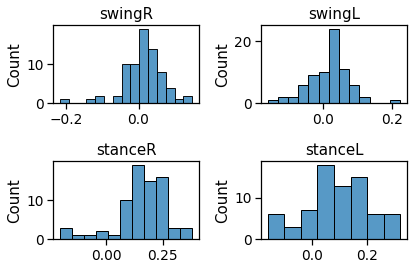

In [32]:
video_annot = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/GoldStandard_TOHS/Video_TOHS/AnnotatedStanceSwingTime.csv')
video_annot.set_index('fileName', inplace=True)
err_video_annot = video_annot.join(Results_df)
#join with pred results for swing and stance
results_ss = Results_df[[c for c in Results_df.columns if 'pred' in c 
                      and ('swing' in c or 'stance' in c) and ('asym' not in c)]]
results_ss = video_annot.merge(results_ss, left_index=True, right_index=True)
cols = ['swingR','swingL','stanceR','stanceL']
fig, ax = plt.subplots(2,2); ax=ax.ravel()
for i,k in enumerate(cols):
    err = results_ss[k+'_pred'] - results_ss[k]
    sns.histplot(err, ax=ax[i]); ax[i].set_title(k)                                           
#     ax[i].scatter(x=results_ss[k], y=results_ss[k+'_pred'])
plt.tight_layout()

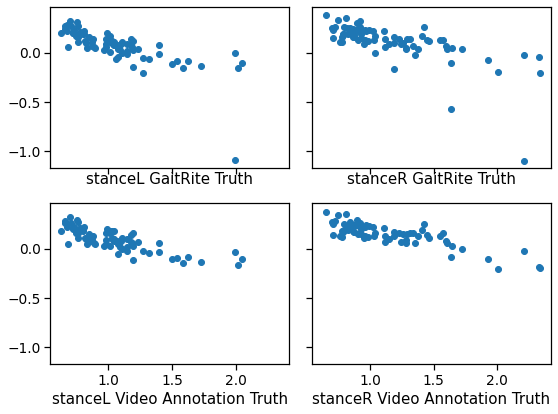

In [33]:
#truth - error for GaitRite and Video Annotations

fig, ax = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True); ax=ax.ravel()
cols = ['stanceL', 'stanceR', 'stanceL', 'stanceR']
for i,k in enumerate(cols):
    if i < 2:
        ax[i].scatter(Results_df[k+'_truth'], err_df[k+'_AbsErr'])
        ax[i].set_xlabel(k + ' GaitRite Truth')
    else:
        err = results_ss[k+'_pred'] - results_ss[k]
        ax[i].scatter(results_ss[k], err)
        ax[i].set_xlabel(k + ' Video Annotation Truth')
    
plt.tight_layout()

In [136]:
video_annot.head()

,swingR,stanceR,swingL,stanceL
fileName,,,,
SS02_3FU_SSV1_Brace,0.48600,0.852500,0.36800,0.982500
SS02_3FU_SSV1_No Brace,0.59875,1.312857,0.36375,1.501429
SS02_3FU_SSV2_Brace,0.47800,0.920000,0.43000,0.965000
SS02_3FU_SSV2_No Brace,0.68000,1.425714,0.37250,1.730000
SS02_3FU_SSV3_Brace,0.53250,0.866667,0.42500,0.980000


### Error against gaitRite

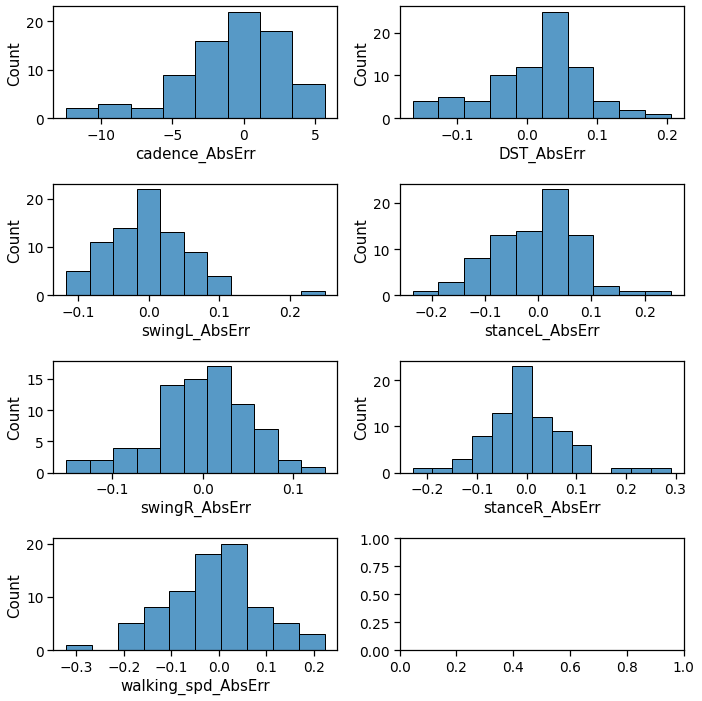

In [39]:
#ABSOLUTE ERROR
fig, ax = plt.subplots(4,2, figsize=(10,10), sharex=False); ax=ax.ravel()
cols = [c for c in err_df.columns if 'Abs' in c]
for i,c in enumerate(err_df[cols]):
    sns.histplot(err_df[c], ax=ax[i])
plt.tight_layout()

#RELATIVE ERROR
# fig, ax = plt.subplots(3,2, figsize=(8,6), sharex=False); ax=ax.ravel()
# cols = [c for c in err_df.columns if 'Rel' in c]
# for i,c in enumerate(err_df[cols]):
#     sns.histplot(err_df[c], ax=ax[i])
# plt.tight_layout()
  
# plt.savefig('./results/Gait/err_hist_kfold.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_hist_kfold_noreg.jpg', dpi=300)


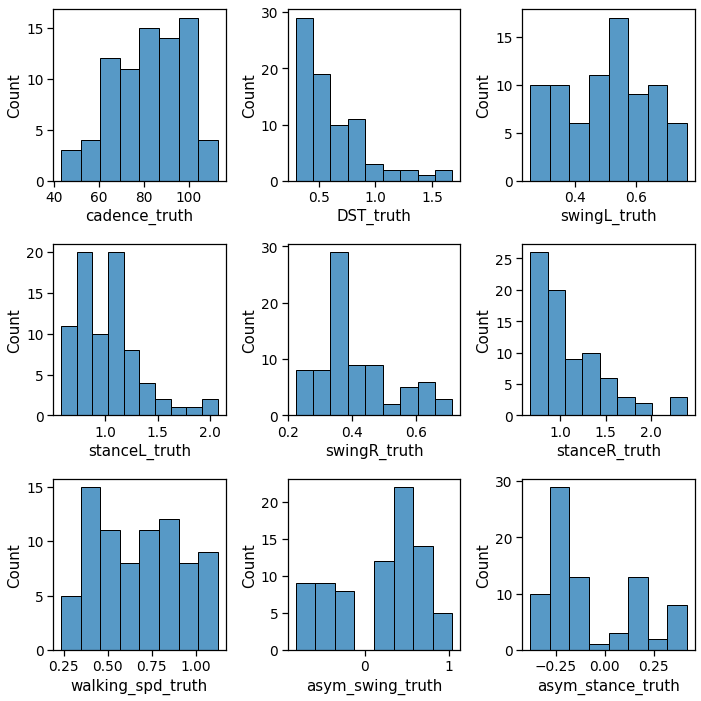

In [40]:
fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=False); ax=ax.ravel()
cols = [c for c in Results_df.columns if 'truth' in c]
for i,c in enumerate(Results_df[cols]):
    sns.histplot(Results_df[c], ax=ax[i])
plt.tight_layout()

plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/truth_distr.jpg', dpi=300)


In [60]:
#Train vs test error
par = 'stanceR'
pred_train = np.concatenate(results[par]['train']['pred']).squeeze()
true_train = np.concatenate(results[par]['train']['labels']).squeeze()
pred_test = np.concatenate(results[par]['pred']).squeeze()
true_test = np.concatenate(results[par]['labels']).squeeze()

err_train = pred_train - true_train
err_test = pred_test - true_test
sns.histplot(err_train)
sns.histplot(err_test, color='orange')
plt.title(par)

KeyError: 'train'

In [361]:
#BAR PLOT OF ABSOLUTE ERRORS 
# plt.figure(figsize=(12,5))
# cols = [c for c in err_df.columns if 'Rel' in c]
# sns.barplot(data=err_df[cols], alpha=.6)
# plt.ylabel('Relative Error [%]')


# # fig, ax = plt.subplots(1,1, figsize=(12,5)); #ax=ax.ravel()
# # # sns.barplot(data=err_df.iloc[:,1:], alpha=.6, ax=ax[0])
# # sns.barplot(data=err_df.iloc[:,0:], alpha=.6, ax=ax[0])
# # ax[0].set_ylabel('Error (Pred - True) [s]')
# # sns.barplot(data=err_df['cadence_err'],ax=ax[1])

# sns.despine()
# plt.tight_layout()
# plt.savefig('./results/Gait/errperc_kfold.jpg', dpi=300)
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/errperc_kfold.jpg', dpi=300)
# # sns.barplot(data=err_df, x=['swingL_err','swingR_err','stanceL_err','stanceR_err'])

In [66]:
err_df.head()
# err_df.sort_values(ascending=False)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingL_AbsErr,swingL_RelErr,stanceL_AbsErr,stanceL_RelErr,swingR_AbsErr,swingR_RelErr,stanceR_AbsErr,stanceR_RelErr
video_id,,,,,,,,,,,,
0,-2.686825,-2.998688,0.153428,36.357399,-0.018317,-4.533833,0.094077,9.892482,0.022078,4.346035,0.225188,27.098433
1,-0.201889,-0.234755,0.129640,28.776978,0.025766,6.871035,-0.023212,-2.244918,-0.020959,-3.783223,0.266939,31.702999
2,-0.817962,-1.185452,0.009490,1.155180,0.064447,12.205877,0.094851,7.761913,0.046253,12.139983,0.114617,8.440127
3,1.872020,2.557404,0.080086,12.681837,-0.023119,-3.753009,0.125367,12.637814,0.048315,13.093399,0.121674,10.156443
4,0.365039,0.423970,0.052775,9.291430,0.103012,40.556038,-0.036758,-3.109837,0.014156,2.328364,0.189068,23.028963


<AxesSubplot:>

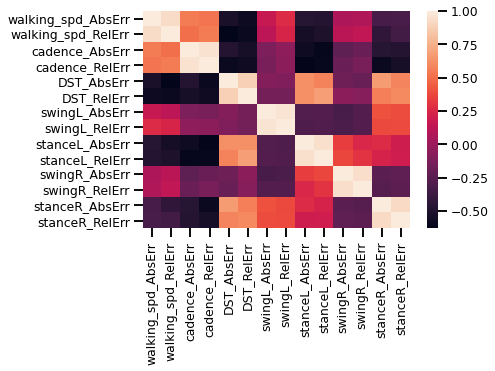

In [99]:
# Results_df
sns.heatmap(err_df.corr())

In [270]:
Results_df = Results_df.groupby(Results_df.index).mean()
Results_df.shape

(79, 12)

In [287]:
# Results_df

## Calculate Asymmetry

In [302]:
# #asymmetry index used
# def calc_asymmetry(L,R):
#     return (L-R)/(L+R)
# #     return (L-R)/(0.5*(L+R))
# #     return L/R

In [99]:
# SubjIds = Results_df_PNP.index.values
# SubjIds = map(str.split('_'),SubjIds)
# Results_df_PNP['SubjID'] = Resu

In [73]:
asym_df

,asym_swing_pred,asym_swing_true,asym_stance_pred,asym_stance_true
SS02_3FU_SSV1_Brace,0.040176,0.432337,-0.519354,-0.666667
SS02_3FU_SSV1_No Brace,0.008886,0.185255,0.099115,0.177215
SS02_3FU_SSV2_Brace,0.053345,0.169972,0.078448,-0.123188
SS02_3FU_SSV2_No Brace,-0.084109,-0.040580,0.096996,0.022739
SS02_3FU_SSV3_Brace,-0.544308,-0.382181,0.027601,-0.046798
...,...,...,...,...
SS22_Post_SSV1_No Brace,0.532804,0.369231,0.121624,0.105704
SS22_Post_SSV2_Brace,0.362501,0.712468,-0.395210,-0.256532
SS22_Post_SSV2_No Brace,0.360170,0.185714,-0.558090,-0.697524
SS22_Post_SSV3_Brace,0.143203,-0.236486,0.011214,-0.182609


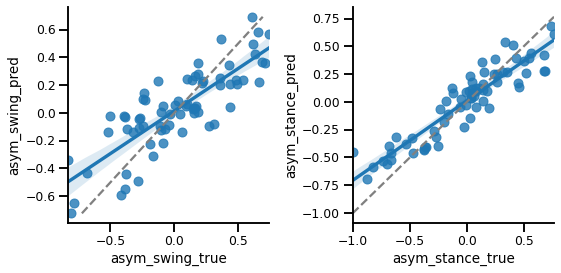

<Figure size 432x288 with 0 Axes>

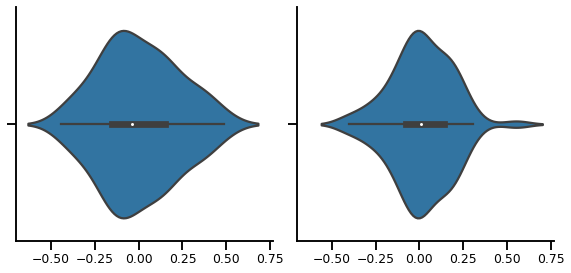

In [79]:
def calc_asymmetry(L,R):
    return (L-R)/(0.5*(L+R))

#plot asymmetry errors
asym_swing_pred = calc_asymmetry(Results_df_PNP['swingP_pred'], Results_df_PNP['swingNP_pred'])
asym_swing_true = calc_asymmetry(Results_df_PNP['swingP_truth'], Results_df_PNP['swingNP_truth'])
asym_stance_pred = calc_asymmetry(Results_df_PNP['stanceP_pred'], Results_df_PNP['stanceNP_pred'])
asym_stance_true = calc_asymmetry(Results_df_PNP['stanceP_truth'], Results_df_PNP['stanceNP_truth'])
asym_df = pd.DataFrame({'asym_swing_pred':asym_swing_pred, 'asym_swing_true':asym_swing_true, 
                        'asym_stance_pred':asym_stance_pred, 'asym_stance_true':asym_stance_true}, 
                      index=Results_df.index)



fig, ax = plt.subplots(1, 2, figsize=(8,4)); ax=ax.ravel()
sns.regplot(data=asym_df, x='asym_swing_true', y='asym_swing_pred', ax=ax[0]); 
sns.regplot(data=asym_df, x='asym_stance_true', y='asym_stance_pred', ax=ax[1]); 
ym = asym_df['asym_swing_true'].min(); yM = asym_df['asym_swing_true'].max()
ax[0].plot([ym, yM], [ym, yM], linestyle='--', c='gray')
ym = asym_df['asym_stance_true'].min(); yM = asym_df['asym_stance_true'].max()
ax[1].plot([ym, yM], [ym, yM], linestyle='--', c='gray')
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_asym'+'.jpg', dpi=300)

plt.figure()

fig, ax = plt.subplots(1, 2, figsize=(8,4), sharex=True); ax=ax.ravel()
sns.violinplot(data=asym_df, x=asym_swing_pred - asym_swing_true, ax=ax[0])
sns.violinplot(data=asym_df, x=asym_stance_pred - asym_stance_true, ax=ax[1])
sns.despine()
plt.tight_layout()
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/asym_err_kfold.jpg', dpi=300)
